In [1]:
import os
current_path = os.getcwd()
import numpy as np
from numpy import seterr
seterr(all='raise')
import matplotlib.pyplot as plt
import math
import random
from tqdm import tqdm
import sys
sys.path.append(current_path)
sys.path.append(current_path+'/../../')
import myInput
import PACKAGE_MP_Linear as linear2d
import post_processing
import PACKAGE_MP_3DLinear as Linear_3D
import PACKAGE_MP_3DVertex as Vertex_3D
sys.path.append(current_path+'/../calculate_tangent/')

import importlib
importlib.reload(post_processing)
importlib.reload(Linear_3D)
importlib.reload(linear2d)



<module 'PACKAGE_MP_Linear' from '/home/lin.yang/projects/VECTOR/examples/GB_velocity/../../PACKAGE_MP_Linear.py'>

## 2D case

In [2]:
if __name__ == '__main__':
    # File name
    data_file_folder = "/blue/michael.tonks/lin.yang/VECTOR_data/"
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_fully/results/"
    # npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_wellEnergy/results/"
    case_name = "MI_20k_fully"
    npy_file_name_aniso = f"p_aveE_fz_fully5d_20k_J1_f1.0_t1.0_refer_1_0_0_seed56689_kt0.66.npy"
    # npy_file_name_aniso = f"p_aveE_20000_Cos_delta0.0_J1_refer_1_0_0_seed56689_kt0.66.npy"
    
    npy_file_name_aniso_energy = f"p_aveE_fz_fully5d_20k_J1_f1.0_t1.0_refer_1_0_0_seed56689_kt0.66_energy.npy"
    # npy_file_name_aniso_energy = f"p_aveE_20000_Cos_delta0.0_J1_refer_1_0_0_seed56689_kt0.66_energy.npy"
    
    # Initial data
    npy_file_aniso = np.load(npy_file_folder + npy_file_name_aniso) # microstructure
    npy_file_aniso = npy_file_aniso.astype(int)
    print(f"The {case_name} data size is: {npy_file_aniso.shape}")
    print("READING DATA DONE")
    npy_file_aniso_energy = np.load(npy_file_folder + npy_file_name_aniso_energy) # energy
    print(f"The {case_name} energy data size is: {npy_file_aniso_energy.shape}")
    print("READING ENERGY DATA DONE")
    step_num, size_x, size_y, size_z = npy_file_aniso.shape

The MI_20k_fully data size is: (201, 2400, 2400, 1)
READING DATA DONE
The MI_20k_fully energy data size is: (201, 2400, 2400, 1)
READING ENERGY DATA DONE


In [3]:
    # GB information
    step_num=121
    grain_nums = 20000
    GB_infomation_dict_list = []
    curvature_matrix_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name = f"GB_velocity_data/2D_signedcurvature_velocity_data_{case_name}_step{time_step}.npz"
        data_curvature_file_name = f"GB_velocity_data/2D_matrix_signedcurvature_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name):
            npz_file = np.load(data_file_folder + data_file_name,allow_pickle=True)
            GB_infomation_dict = npz_file["GB_infomation_dict"]
            GB_infomation_dict_list.append(GB_infomation_dict.item())
        else:
            current_microstructure = npy_file_aniso[time_step]
            # get curvature with sign
            if os.path.exists(data_file_folder + data_curvature_file_name):
                npz_file_curvature = np.load(data_file_folder + data_curvature_file_name)
                curvature_matrix = npz_file_curvature["curvature_matrix"]
                curvature_matrix_list.append(curvature_matrix)
            else:
                cores = 128
                loop_times = 5
                R = np.zeros((size_x,size_y,3))
                smoothing_class = linear2d.linear_class(size_x,size_y,grain_nums,cores,loop_times,current_microstructure[:,:,0],R,verification_system = False,curvature_sign = True)
                smoothing_class.linear_main("curvature")
                C_ln = smoothing_class.get_C()
                curvature_matrix = C_ln[1,:]
                curvature_matrix_list.append(curvature_matrix)
                # save curvature information
                # np.savez(data_file_folder + data_curvature_file_name, curvature_matrix=curvature_matrix)
            print("Finish curvature calculation")
            
            # Get TJ and QJ information first
            TJ_infomation_dict = dict()
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[im,j,k], current_microstructure[i,jm,k]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: 
                        for m in range(len(neighboring_sites_list_unque)):
                            pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
                            if pair_id in TJ_infomation_dict:
                                tmp = TJ_infomation_dict[pair_id]
                                tmp.append([i,j,k])
                                TJ_infomation_dict[pair_id] = tmp
                            else: 
                                TJ_infomation_dict[pair_id] = [[i,j,k]]
            print("Finish TJ extraction")
            
            # Get the center of each GB
            GB_infomation_dict = dict()
            TJ_distance_max = 6 # voxels
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[im,j,k], current_microstructure[i,jm,k]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    # CONTINUE...    # remove the voxels around TJs and QJs
                    # check the GB voxels is close to TJ or not
                    break_point = 0
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GB_infomation_dict:
                        GB_infomation_dict[pair_id][5] += 1 # GB area
                    else:
                        GB_infomation = np.array([0,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-curvature,i,j,k,curvature,GBnum,gid0,gid1
                        GB_infomation_dict[pair_id] = GB_infomation
                    if pair_id in TJ_infomation_dict:
                        for TJ_site in TJ_infomation_dict[pair_id]:
                            TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                            if TJ_distance < TJ_distance_max: 
                                break_point = 1
                                break
                    if break_point == 1: continue
                    # calculate or extract misorientation
                    # if pair_id in GB_infomation_dict:
                    GB_infomation_dict[pair_id][0] += 1
                    if central_site == pair_id_pair[0]:
                        GB_infomation_dict[pair_id][1:5] += np.array([i,j,k,curvature_matrix[i,j]])
                    else:
                        GB_infomation_dict[pair_id][1:5] += np.array([i,j,k,-curvature_matrix[i,j]])
                    
            # get the correct location for each GB
            small_GB_list = []
            for key in GB_infomation_dict: 
                if GB_infomation_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GB_infomation_dict.pop(small_GB_list[s_index])
            for key in GB_infomation_dict: 
                GB_infomation_dict[key][1:5]=GB_infomation_dict[key][1:5]/GB_infomation_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GB_infomation_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name, GB_infomation_dict=GB_infomation_dict)
            GB_infomation_dict_list.append(GB_infomation_dict)

100%|██████████| 121/121 [00:01<00:00, 87.45it/s] 


In [4]:
    # GB Energy information
    step_num=121
    grain_nums = 20000
    GBenergy_information_dict_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name_GBenergy = f"GB_velocity_data/2D_GBenergy_velocity_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name_GBenergy):
            npz_file = np.load(data_file_folder + data_file_name_GBenergy,allow_pickle=True)
            GBenergy_information_dict = npz_file["GBenergy_information_dict"]
            GBenergy_information_dict_list.append(GBenergy_information_dict.item())
        else:
            current_microstructure = npy_file_aniso[time_step]
            current_energy = npy_file_aniso_energy[time_step]

            # Get TJ and QJ information first
            TJ_infomation_dict = dict()
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[im,j,k], current_microstructure[i,jm,k]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: 
                        for m in range(len(neighboring_sites_list_unque)):
                            pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
                            if pair_id in TJ_infomation_dict:
                                tmp = TJ_infomation_dict[pair_id]
                                tmp.append([i,j,k])
                                TJ_infomation_dict[pair_id] = tmp
                            else: 
                                TJ_infomation_dict[pair_id] = [[i,j,k]]
            print("Finish TJ extraction")

            # Get the center of each GB
            GBenergy_information_dict = dict()
            TJ_distance_max = 6 # voxels
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[im,j,k], current_microstructure[i,jm,k]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    num_other_sites = 0
                    neighboring_sites_full_list = np.array([current_microstructure[ip,jp,k], current_microstructure[ip,j,k], current_microstructure[ip,jm,k], current_microstructure[i,jp,k], current_microstructure[i,jm,k], current_microstructure[im,jp,k], current_microstructure[im,j,k], current_microstructure[im,jm,k]]).astype(int)
                    for neigh_site in neighboring_sites_full_list:
                        if neigh_site != central_site: num_other_sites += 1 # get the sites num different with central id
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    # CONTINUE...    # remove the voxels around TJs and QJs
                    # check the GB voxels is close to TJ or not
                    break_point = 0
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GBenergy_information_dict:
                        GBenergy_information_dict[pair_id][5] += 1 # GB area
                    else:
                        GB_infomation = np.array([0,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-energy,i,j,k,GB energy,GBnum,gid0,gid1
                        GBenergy_information_dict[pair_id] = GB_infomation
                    if pair_id in TJ_infomation_dict:
                        for TJ_site in TJ_infomation_dict[pair_id]:
                            TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                            if TJ_distance < TJ_distance_max: 
                                break_point = 1
                                break
                    if break_point == 1: continue
                    # calculate or extract misorientation
                    # if pair_id in GBenergy_information_dict:
                    GBenergy_information_dict[pair_id][0] += 1
                    GBenergy_information_dict[pair_id][1:5] += np.array([i,j,k,current_energy[i,j,k]/num_other_sites])

            # get the correct location for each GB
            small_GB_list = []
            for key in GBenergy_information_dict: 
                if GBenergy_information_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GBenergy_information_dict.pop(small_GB_list[s_index])
            for key in GBenergy_information_dict: 
                GBenergy_information_dict[key][1:5]=GBenergy_information_dict[key][1:5]/GBenergy_information_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GBenergy_information_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name_GBenergy, GBenergy_information_dict=GBenergy_information_dict)
            GBenergy_information_dict_list.append(GBenergy_information_dict)

100%|██████████| 121/121 [00:01<00:00, 96.95it/s] 


In [5]:
    time_interval = 30
    low_curvature_limit = 0.0182
    # store all GB points, include curvature and anti-curvature(include randomness points)
    GB_list_velocity_list = []
    GB_list_curvature_list = []
    GB_list_GBenergy_list = []
    # store all GB point exclude anti-curvature randomness points
    GB_list_velocity_list_exrandom = []
    GB_list_curvature_list_exrandom = []
    # store GB energy point exclude anti_c randomness points
    GB_list_GBenergy_list_exrandom = []
    # store anti-curvature GBs in dictionary
    GB_id_focus = dict()
    GB_id_focus_detail = dict()
    GB_filter_kernel = [set(),set(),set(),set(),set()]
    for time_step in range(step_num):
        if time_step+1 >= step_num: continue
        GB_list_velocity_list_tmp = []
        GB_list_curvature_list_tmp = []
        GB_list_GBenergy_list_tmp = []
        GB_list_velocity_list_exrandom_tmp = []
        GB_list_curvature_list_exrandom_tmp = []
        GB_list_GBenergy_list_exrandom_tmp = []
        key_set = set()
        for key in tqdm(GB_infomation_dict_list[time_step]):
            if GB_infomation_dict_list[time_step+1].get(key) is None: continue
            if GB_infomation_dict_list[time_step][key][5] < 100: continue # remove small GBs
            if abs(GB_infomation_dict_list[time_step][key][4]) < low_curvature_limit: continue # remove low curvature
            # Calculate dV
            pair_id_pair = GB_infomation_dict_list[time_step][key][6:8]
            growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair[0])*(npy_file_aniso[time_step+1]==pair_id_pair[1])
            growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair[1])*(npy_file_aniso[time_step+1]==pair_id_pair[0])
            dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
            # calculate velocity
            velocity = dV/time_interval/(GB_infomation_dict_list[time_step][key][5]/2)
            GB_list_velocity_list_tmp.append(velocity)
            # keep curvature
            current_curvature_value = GB_infomation_dict_list[time_step][key][4]
            GB_list_curvature_list_tmp.append(current_curvature_value)
            # keep GB energy
            GB_list_GBenergy_list_tmp.append(GBenergy_information_dict_list[time_step][key][4])
            
            # keep anti-curvature GB info
            if current_curvature_value*velocity<-0.0001: 
                key_set.add(key)
                if time_step >= step_num-3: continue
                if key in GB_id_focus: 
                    GB_id_focus[key] += 1
                    GB_id_focus_detail[key].append(time_step)
                else: 
                    GB_id_focus[key] = 1
                    GB_id_focus_detail[key] = [time_step]
        
        # keep all GBs with GB length larger than 100
        GB_list_velocity_list.append(GB_list_velocity_list_tmp)
        GB_list_curvature_list.append(GB_list_curvature_list_tmp)
        GB_list_GBenergy_list.append(GB_list_GBenergy_list_tmp)
        
        # filter the anti-curvature GB with 00100
        GB_filter_kernel[0:4] = GB_filter_kernel[1:]
        GB_filter_kernel[4] = key_set
        filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[0]|GB_filter_kernel[1]|GB_filter_kernel[3]|GB_filter_kernel[4])
        for key in filtered_set: 
            GB_id_focus[key] -= 1
            GB_id_focus_detail[key].remove(time_step-2)
        print(f"finish {time_step} with num of GBs {len(GB_list_velocity_list_tmp)}, and collected num of GBs {len(GB_id_focus)}")
        
        # remove exclude data
        if time_step < 2: continue
        for key in tqdm(GB_infomation_dict_list[time_step-2]):
            if GB_infomation_dict_list[time_step-1].get(key) is None: continue
            if GB_infomation_dict_list[time_step-2][key][5] < 100: continue # remove small GBs
            if key in filtered_set: continue # remove the randomness points
            if abs(GB_infomation_dict_list[time_step-2][key][4]) < low_curvature_limit: continue # remove low curvature
            # Calculate dV
            pair_id_pair = GB_infomation_dict_list[time_step-2][key][6:8]
            growth_direction1 = (npy_file_aniso[time_step-2]==pair_id_pair[0])*(npy_file_aniso[time_step-1]==pair_id_pair[1])
            growth_direction2 = (npy_file_aniso[time_step-2]==pair_id_pair[1])*(npy_file_aniso[time_step-1]==pair_id_pair[0])
            dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
            # calculate velocity
            velocity = dV/time_interval/(GB_infomation_dict_list[time_step-2][key][5]/2)
            GB_list_velocity_list_exrandom_tmp.append(velocity)
            # keep curvature
            current_curvature_value = GB_infomation_dict_list[time_step-2][key][4]
            GB_list_curvature_list_exrandom_tmp.append(current_curvature_value)
            # keep GB energy
            GB_list_GBenergy_list_exrandom_tmp.append(GBenergy_information_dict_list[time_step-2][key][4])
        GB_list_velocity_list_exrandom.append(GB_list_velocity_list_exrandom_tmp)
        GB_list_curvature_list_exrandom.append(GB_list_curvature_list_exrandom_tmp)
        GB_list_GBenergy_list_exrandom.append(GB_list_GBenergy_list_exrandom_tmp)
        
    
    # filter the anti-curvature GB with 00100
    GB_id_focus_copy = GB_id_focus.copy()
    for key in GB_id_focus_copy:
        if GB_id_focus_copy[key] <=0:
            GB_id_focus.pop(key)
            GB_id_focus_detail.pop(key)
            
    # add the last two steps for exclude data
    # GB_list_velocity_list_exrandom.extend(GB_list_velocity_list[-2:])
    # GB_list_curvature_list_exrandom.extend(GB_list_curvature_list[-2:])
    # GB_list_GBenergy_list_exrandom.extend(GB_list_GBenergy_list[-2:])
            

100%|██████████| 22827/22827 [00:00<00:00, 1951954.69it/s]


finish 0 with num of GBs 0, and collected num of GBs 0


100%|██████████| 18957/18957 [00:00<00:00, 49030.58it/s]


finish 1 with num of GBs 15, and collected num of GBs 6


100%|██████████| 16156/16156 [00:01<00:00, 10140.64it/s]


finish 2 with num of GBs 64, and collected num of GBs 23


100%|██████████| 13834/13834 [00:02<00:00, 5257.58it/s]


finish 3 with num of GBs 106, and collected num of GBs 61


100%|██████████| 11980/11980 [00:04<00:00, 2779.61it/s]


finish 4 with num of GBs 174, and collected num of GBs 117


100%|██████████| 10494/10494 [00:06<00:00, 1634.61it/s]


finish 5 with num of GBs 259, and collected num of GBs 194


100%|██████████| 9305/9305 [00:07<00:00, 1229.06it/s]


finish 6 with num of GBs 305, and collected num of GBs 267


100%|██████████| 8450/8450 [00:08<00:00, 1029.61it/s]


finish 7 with num of GBs 331, and collected num of GBs 353


100%|██████████| 7701/7701 [00:08<00:00, 927.17it/s] 


finish 8 with num of GBs 336, and collected num of GBs 437


100%|██████████| 7107/7107 [00:07<00:00, 916.47it/s] 


finish 9 with num of GBs 313, and collected num of GBs 513


100%|██████████| 6606/6606 [00:08<00:00, 799.70it/s] 


finish 10 with num of GBs 333, and collected num of GBs 597


100%|██████████| 6184/6184 [00:08<00:00, 722.70it/s]


finish 11 with num of GBs 345, and collected num of GBs 680


100%|██████████| 5777/5777 [00:07<00:00, 757.29it/s] 


finish 12 with num of GBs 307, and collected num of GBs 748


100%|██████████| 5411/5411 [00:08<00:00, 625.51it/s] 


finish 13 with num of GBs 348, and collected num of GBs 819


100%|██████████| 5112/5112 [00:08<00:00, 591.74it/s]


finish 14 with num of GBs 347, and collected num of GBs 890


100%|██████████| 4791/4791 [00:07<00:00, 618.48it/s]


finish 15 with num of GBs 312, and collected num of GBs 952


100%|██████████| 4564/4564 [00:08<00:00, 543.66it/s]


finish 16 with num of GBs 337, and collected num of GBs 1015


100%|██████████| 4385/4385 [00:07<00:00, 548.58it/s]


finish 17 with num of GBs 322, and collected num of GBs 1076


100%|██████████| 4154/4154 [00:07<00:00, 525.23it/s]


finish 18 with num of GBs 317, and collected num of GBs 1130


100%|██████████| 3960/3960 [00:07<00:00, 528.78it/s]


finish 19 with num of GBs 305, and collected num of GBs 1175


100%|██████████| 3813/3813 [00:07<00:00, 537.63it/s]


finish 20 with num of GBs 289, and collected num of GBs 1217


100%|██████████| 3648/3648 [00:06<00:00, 562.40it/s]


finish 21 with num of GBs 265, and collected num of GBs 1256


100%|██████████| 3511/3511 [00:06<00:00, 515.19it/s]


finish 22 with num of GBs 277, and collected num of GBs 1305


100%|██████████| 3377/3377 [00:06<00:00, 514.58it/s]


finish 23 with num of GBs 267, and collected num of GBs 1349


100%|██████████| 3281/3281 [00:06<00:00, 504.21it/s]


finish 24 with num of GBs 264, and collected num of GBs 1380


100%|██████████| 3164/3164 [00:06<00:00, 455.35it/s]


finish 25 with num of GBs 282, and collected num of GBs 1431


100%|██████████| 3067/3067 [00:05<00:00, 511.82it/s]


finish 26 with num of GBs 244, and collected num of GBs 1463


100%|██████████| 2930/2930 [00:05<00:00, 512.78it/s]


finish 27 with num of GBs 232, and collected num of GBs 1494


100%|██████████| 2840/2840 [00:05<00:00, 482.45it/s]


finish 28 with num of GBs 239, and collected num of GBs 1517


100%|██████████| 2744/2744 [00:06<00:00, 429.40it/s]


finish 29 with num of GBs 247, and collected num of GBs 1562


100%|██████████| 2675/2675 [00:06<00:00, 408.04it/s]


finish 30 with num of GBs 253, and collected num of GBs 1608


100%|██████████| 2579/2579 [00:06<00:00, 416.60it/s]


finish 31 with num of GBs 246, and collected num of GBs 1643


100%|██████████| 2511/2511 [00:05<00:00, 464.54it/s]


finish 32 with num of GBs 215, and collected num of GBs 1674


100%|██████████| 2441/2441 [00:05<00:00, 438.36it/s]


finish 33 with num of GBs 219, and collected num of GBs 1696


100%|██████████| 2378/2378 [00:05<00:00, 405.10it/s]


finish 34 with num of GBs 229, and collected num of GBs 1732


100%|██████████| 2344/2344 [00:05<00:00, 408.91it/s]


finish 35 with num of GBs 224, and collected num of GBs 1764


100%|██████████| 2320/2320 [00:04<00:00, 485.62it/s]


finish 36 with num of GBs 186, and collected num of GBs 1783


100%|██████████| 2254/2254 [00:05<00:00, 435.50it/s]


finish 37 with num of GBs 203, and collected num of GBs 1814


100%|██████████| 2193/2193 [00:04<00:00, 476.68it/s]


finish 38 with num of GBs 181, and collected num of GBs 1823


100%|██████████| 2151/2151 [00:04<00:00, 435.29it/s]


finish 39 with num of GBs 193, and collected num of GBs 1849


100%|██████████| 2075/2075 [00:04<00:00, 445.96it/s]


finish 40 with num of GBs 182, and collected num of GBs 1868


100%|██████████| 2032/2032 [00:05<00:00, 391.19it/s]


finish 41 with num of GBs 203, and collected num of GBs 1890


100%|██████████| 1983/1983 [00:04<00:00, 445.22it/s]


finish 42 with num of GBs 174, and collected num of GBs 1912


100%|██████████| 1928/1928 [00:04<00:00, 418.45it/s]


finish 43 with num of GBs 180, and collected num of GBs 1926


100%|██████████| 1908/1908 [00:04<00:00, 392.62it/s]


finish 44 with num of GBs 190, and collected num of GBs 1944


100%|██████████| 1883/1883 [00:04<00:00, 462.85it/s]


finish 45 with num of GBs 159, and collected num of GBs 1961


100%|██████████| 1852/1852 [00:03<00:00, 501.42it/s]


finish 46 with num of GBs 145, and collected num of GBs 1976


100%|██████████| 1813/1813 [00:03<00:00, 535.21it/s]


finish 47 with num of GBs 133, and collected num of GBs 1991


100%|██████████| 1768/1768 [00:03<00:00, 448.68it/s]


finish 48 with num of GBs 155, and collected num of GBs 2002


100%|██████████| 1737/1737 [00:03<00:00, 471.08it/s]


finish 49 with num of GBs 145, and collected num of GBs 2014


100%|██████████| 1700/1700 [00:03<00:00, 448.71it/s]


finish 50 with num of GBs 149, and collected num of GBs 2025


100%|██████████| 1672/1672 [00:03<00:00, 483.50it/s]


finish 51 with num of GBs 136, and collected num of GBs 2042


100%|██████████| 1653/1653 [00:04<00:00, 408.08it/s]


finish 52 with num of GBs 159, and collected num of GBs 2055


100%|██████████| 1629/1629 [00:03<00:00, 468.13it/s]


finish 53 with num of GBs 137, and collected num of GBs 2074


100%|██████████| 1595/1595 [00:03<00:00, 438.92it/s]


finish 54 with num of GBs 143, and collected num of GBs 2084


100%|██████████| 1566/1566 [00:03<00:00, 513.57it/s]


finish 55 with num of GBs 120, and collected num of GBs 2097


100%|██████████| 1542/1542 [00:03<00:00, 430.57it/s]


finish 56 with num of GBs 140, and collected num of GBs 2109


100%|██████████| 1512/1512 [00:03<00:00, 442.42it/s]


finish 57 with num of GBs 134, and collected num of GBs 2120


100%|██████████| 1495/1495 [00:03<00:00, 437.83it/s]


finish 58 with num of GBs 134, and collected num of GBs 2130


100%|██████████| 1480/1480 [00:03<00:00, 400.89it/s]


finish 59 with num of GBs 145, and collected num of GBs 2139


100%|██████████| 1447/1447 [00:03<00:00, 420.46it/s]


finish 60 with num of GBs 135, and collected num of GBs 2149


100%|██████████| 1429/1429 [00:03<00:00, 412.75it/s]


finish 61 with num of GBs 136, and collected num of GBs 2160


100%|██████████| 1396/1396 [00:03<00:00, 449.66it/s]


finish 62 with num of GBs 122, and collected num of GBs 2168


100%|██████████| 1381/1381 [00:02<00:00, 516.26it/s]


finish 63 with num of GBs 105, and collected num of GBs 2180


100%|██████████| 1367/1367 [00:02<00:00, 488.13it/s]


finish 64 with num of GBs 110, and collected num of GBs 2186


100%|██████████| 1356/1356 [00:03<00:00, 450.75it/s]


finish 65 with num of GBs 118, and collected num of GBs 2203


100%|██████████| 1333/1333 [00:02<00:00, 508.89it/s]


finish 66 with num of GBs 103, and collected num of GBs 2212


100%|██████████| 1318/1318 [00:02<00:00, 449.77it/s]


finish 67 with num of GBs 115, and collected num of GBs 2224


100%|██████████| 1300/1300 [00:02<00:00, 447.75it/s]


finish 68 with num of GBs 114, and collected num of GBs 2232


100%|██████████| 1269/1269 [00:02<00:00, 488.64it/s]


finish 69 with num of GBs 102, and collected num of GBs 2239


100%|██████████| 1251/1251 [00:02<00:00, 446.57it/s]


finish 70 with num of GBs 110, and collected num of GBs 2246


100%|██████████| 1247/1247 [00:02<00:00, 476.66it/s]


finish 71 with num of GBs 103, and collected num of GBs 2253


100%|██████████| 1221/1221 [00:02<00:00, 564.39it/s]


finish 72 with num of GBs 85, and collected num of GBs 2257


100%|██████████| 1205/1205 [00:02<00:00, 525.61it/s]


finish 73 with num of GBs 90, and collected num of GBs 2271


100%|██████████| 1187/1187 [00:02<00:00, 560.90it/s]


finish 74 with num of GBs 83, and collected num of GBs 2274


100%|██████████| 1161/1161 [00:01<00:00, 723.74it/s]


finish 75 with num of GBs 63, and collected num of GBs 2279


100%|██████████| 1137/1137 [00:02<00:00, 564.88it/s]


finish 76 with num of GBs 79, and collected num of GBs 2283


100%|██████████| 1114/1114 [00:02<00:00, 464.01it/s]


finish 77 with num of GBs 94, and collected num of GBs 2294


100%|██████████| 1097/1097 [00:02<00:00, 474.48it/s]


finish 78 with num of GBs 91, and collected num of GBs 2302


100%|██████████| 1084/1084 [00:01<00:00, 635.11it/s]


finish 79 with num of GBs 67, and collected num of GBs 2308


100%|██████████| 1079/1079 [00:01<00:00, 543.54it/s]


finish 80 with num of GBs 78, and collected num of GBs 2315


100%|██████████| 1062/1062 [00:01<00:00, 555.40it/s]


finish 81 with num of GBs 75, and collected num of GBs 2318


100%|██████████| 1054/1054 [00:02<00:00, 497.93it/s]


finish 82 with num of GBs 83, and collected num of GBs 2324


100%|██████████| 1032/1032 [00:01<00:00, 562.36it/s]


finish 83 with num of GBs 72, and collected num of GBs 2331


100%|██████████| 1028/1028 [00:01<00:00, 621.57it/s]


finish 84 with num of GBs 65, and collected num of GBs 2341


100%|██████████| 1020/1020 [00:01<00:00, 644.75it/s]


finish 85 with num of GBs 62, and collected num of GBs 2344


100%|██████████| 1009/1009 [00:02<00:00, 462.63it/s]


finish 86 with num of GBs 86, and collected num of GBs 2355


100%|██████████| 995/995 [00:01<00:00, 559.06it/s]


finish 87 with num of GBs 70, and collected num of GBs 2365


100%|██████████| 986/986 [00:01<00:00, 517.18it/s]


finish 88 with num of GBs 75, and collected num of GBs 2374


100%|██████████| 980/980 [00:02<00:00, 443.45it/s] 


finish 89 with num of GBs 87, and collected num of GBs 2382


100%|██████████| 969/969 [00:02<00:00, 471.55it/s]


finish 90 with num of GBs 81, and collected num of GBs 2385


100%|██████████| 966/966 [00:01<00:00, 519.08it/s]


finish 91 with num of GBs 73, and collected num of GBs 2388


100%|██████████| 950/950 [00:01<00:00, 532.79it/s]


finish 92 with num of GBs 70, and collected num of GBs 2395


100%|██████████| 934/934 [00:01<00:00, 517.43it/s]


finish 93 with num of GBs 71, and collected num of GBs 2401


100%|██████████| 933/933 [00:01<00:00, 749.17it/s] 


finish 94 with num of GBs 49, and collected num of GBs 2405


100%|██████████| 919/919 [00:01<00:00, 531.21it/s]


finish 95 with num of GBs 68, and collected num of GBs 2410


100%|██████████| 895/895 [00:01<00:00, 558.23it/s]


finish 96 with num of GBs 63, and collected num of GBs 2416


100%|██████████| 898/898 [00:01<00:00, 677.76it/s] 


finish 97 with num of GBs 52, and collected num of GBs 2419


100%|██████████| 879/879 [00:01<00:00, 628.67it/s] 


finish 98 with num of GBs 55, and collected num of GBs 2426


100%|██████████| 874/874 [00:01<00:00, 520.11it/s]


finish 99 with num of GBs 66, and collected num of GBs 2434


100%|██████████| 869/869 [00:01<00:00, 620.49it/s]


finish 100 with num of GBs 55, and collected num of GBs 2437


100%|██████████| 855/855 [00:01<00:00, 509.14it/s]


finish 101 with num of GBs 66, and collected num of GBs 2442


100%|██████████| 843/843 [00:01<00:00, 689.42it/s]


finish 102 with num of GBs 48, and collected num of GBs 2445


100%|██████████| 835/835 [00:01<00:00, 437.64it/s] 


finish 103 with num of GBs 75, and collected num of GBs 2449


100%|██████████| 837/837 [00:01<00:00, 556.58it/s]


finish 104 with num of GBs 59, and collected num of GBs 2452


100%|██████████| 829/829 [00:01<00:00, 453.43it/s]


finish 105 with num of GBs 72, and collected num of GBs 2458


100%|██████████| 817/817 [00:01<00:00, 630.21it/s] 


finish 106 with num of GBs 51, and collected num of GBs 2463


100%|██████████| 815/815 [00:01<00:00, 464.16it/s]


finish 107 with num of GBs 69, and collected num of GBs 2468


100%|██████████| 815/815 [00:01<00:00, 507.82it/s]


finish 108 with num of GBs 63, and collected num of GBs 2474


100%|██████████| 806/806 [00:01<00:00, 501.98it/s]


finish 109 with num of GBs 63, and collected num of GBs 2476


100%|██████████| 798/798 [00:01<00:00, 551.17it/s]


finish 110 with num of GBs 57, and collected num of GBs 2477


100%|██████████| 793/793 [00:01<00:00, 547.14it/s]


finish 111 with num of GBs 57, and collected num of GBs 2482


100%|██████████| 783/783 [00:01<00:00, 628.76it/s] 


finish 112 with num of GBs 49, and collected num of GBs 2484


100%|██████████| 781/781 [00:01<00:00, 539.52it/s]


finish 113 with num of GBs 57, and collected num of GBs 2488


100%|██████████| 780/780 [00:01<00:00, 625.21it/s]


finish 114 with num of GBs 49, and collected num of GBs 2494


100%|██████████| 769/769 [00:01<00:00, 672.05it/s] 


finish 115 with num of GBs 45, and collected num of GBs 2497


100%|██████████| 762/762 [00:01<00:00, 507.49it/s]


finish 116 with num of GBs 59, and collected num of GBs 2500


100%|██████████| 760/760 [00:01<00:00, 635.19it/s]


finish 117 with num of GBs 47, and collected num of GBs 2501


100%|██████████| 744/744 [00:01<00:00, 584.62it/s]


finish 118 with num of GBs 50, and collected num of GBs 2501


100%|██████████| 735/735 [00:01<00:00, 600.73it/s]


finish 119 with num of GBs 48, and collected num of GBs 2501


100%|██████████| 760/760 [00:00<00:00, 803.43it/s]


In [12]:
len(GB_id_focus)

520

In [7]:
    time_interval = 30
    # GB_list_velocity_list = []
    GB_antic_list_velocity_list = []
    GB_antic_list_GBenergy_list = []
    GB_antic_list_anticNum_list = []
    GB_id_unfocus_lowE_detail = dict()
    for time_step in range(step_num):
        if time_step+1 >= step_num: continue
        for key in tqdm(GBenergy_information_dict_list[time_step]):
            if GBenergy_information_dict_list[time_step+1].get(key) is None: continue
            if GBenergy_information_dict_list[time_step][key][5] < 100: continue # remove small GBs
            if abs(GB_infomation_dict_list[time_step][key][4]) < low_curvature_limit: continue # remove low curvature
            
            # keep the GB with low energy and curvature behavior
            if (GBenergy_information_dict_list[time_step][key][4]<0.4) and (key not in GB_id_focus_detail): # do we need to remove random here?
                if key in GB_id_unfocus_lowE_detail:
                    GB_id_unfocus_lowE_detail[key].append(time_step)
                else:
                    GB_id_unfocus_lowE_detail[key] = [time_step]
            
            # anti-curvature behavior list
            if (key in GB_id_focus_detail) and (time_step in GB_id_focus_detail[key]):
                # Calculate dV
                pair_id_pair = GB_infomation_dict_list[time_step][key][6:8]
                growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair[0])*(npy_file_aniso[time_step+1]==pair_id_pair[1])
                growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair[1])*(npy_file_aniso[time_step+1]==pair_id_pair[0])
                dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
                # calculate velocity
                velocity = dV/time_interval/(GB_infomation_dict_list[time_step][key][5]/2)
                # correct the sign of velocity
                current_curvature_value = GB_infomation_dict_list[time_step][key][4]
                if current_curvature_value < 0: GB_antic_list_velocity_list.append(-velocity)
                else: GB_antic_list_velocity_list.append(velocity)
                
                GB_antic_list_GBenergy_list.append(GBenergy_information_dict_list[time_step][key][4])
                GB_antic_list_anticNum_list.append(GB_id_focus[key])
            
        
            

100%|██████████| 735/735 [00:00<00:00, 1079038.66it/s]


In [8]:
    total_GB = set()
    for time_step in range(step_num):
        step_GB = GB_infomation_dict_list[time_step].keys()
        total_GB = total_GB | step_GB

    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(GB_id_focus.values())}")
    print(f"The ratio of anti-curvature GBs during whole simulations is {len(GB_id_focus.values())/len(total_GB)*100}% in {len(total_GB)} GBs")
    print(GB_id_focus.values())

The number of the GBs showing anti-curvature during whole simulations is 520
The ratio of anti-curvature GBs during whole simulations is 0.9643201542912248% in 53924 GBs
dict_values([2, 2, 2, 2, 6, 2, 2, 3, 2, 2, 3, 4, 2, 2, 8, 2, 5, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 5, 3, 2, 2, 3, 3, 5, 2, 2, 2, 2, 4, 6, 2, 4, 4, 4, 2, 3, 2, 2, 2, 2, 4, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 4, 2, 2, 5, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 6, 4, 2, 2, 2, 2, 2, 2, 4, 2, 8, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 9, 2, 4, 10, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 3, 2, 2, 4, 16, 4, 2, 3, 2, 2, 2, 2, 2, 2, 4, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 4, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 8, 2, 3, 4, 2, 2, 2, 2, 2, 4, 3, 2, 2, 2, 4, 2, 2, 4, 2, 2, 5, 3, 2, 2, 2, 2, 2, 2, 3, 4, 4, 2, 2, 2, 2, 2, 3, 4, 3, 4, 2, 2, 6, 3, 2, 2, 2, 2, 2, 3, 3, 3, 4, 2, 2, 6, 2, 2, 11, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 4, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 2, 2

<Figure size 432x288 with 0 Axes>

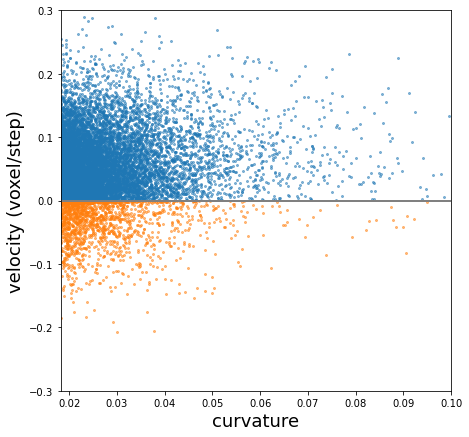

<Figure size 432x288 with 0 Axes>

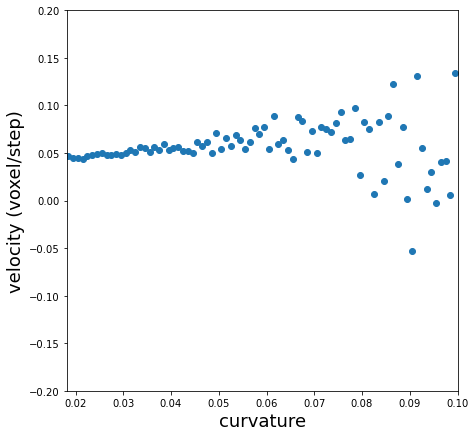

In [19]:
    # All in 1 figrue
    curvature_1Dlist_remove_0step = []
    velocity_1Dlist_remove_0step = []
    # GBenergy_1Dlist_remove_0step = []
    for i in range(0,len(GB_list_velocity_list)): 
        curvature_1Dlist_remove_0step.extend(GB_list_curvature_list[i])
        velocity_1Dlist_remove_0step.extend(GB_list_velocity_list[i])
        # GBenergy_1Dlist_remove_0step.extend(GB_list_GBenergy_list[i])
    curvature_1Dlist_exrandom_remove_0step = []
    velocity_1Dlist_exrandom_remove_0step = []
    # GBenergy_1Dlist_exrandom_remove_0step = []
    for i in range(0,len(GB_list_velocity_list_exrandom)): 
        curvature_1Dlist_exrandom_remove_0step.extend(GB_list_curvature_list_exrandom[i])
        velocity_1Dlist_exrandom_remove_0step.extend(GB_list_velocity_list_exrandom[i])
        # GBenergy_1Dlist_exrandom_remove_0step.extend(GB_list_GBenergy_list_exrandom[i])
    
    # ignore the sign of curvature
    for i in range(len(curvature_1Dlist_exrandom_remove_0step)):
        if curvature_1Dlist_exrandom_remove_0step[i]<0: 
            curvature_1Dlist_exrandom_remove_0step[i] = - curvature_1Dlist_exrandom_remove_0step[i]
            velocity_1Dlist_exrandom_remove_0step[i] = - velocity_1Dlist_exrandom_remove_0step[i]
    velocity_1Dlist_exrandom_remove_0step = np.array(velocity_1Dlist_exrandom_remove_0step)
    curvature_1Dlist_exrandom_remove_0step = np.array(curvature_1Dlist_exrandom_remove_0step)
            
    figure_name_all = f"figures/2D_velocity_signedcurvature_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.plot([low_curvature_limit,0.1],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(curvature_1Dlist_exrandom_remove_0step[velocity_1Dlist_exrandom_remove_0step>0], velocity_1Dlist_exrandom_remove_0step[velocity_1Dlist_exrandom_remove_0step>0],s=4,alpha=0.5)
    plt.scatter(curvature_1Dlist_exrandom_remove_0step[velocity_1Dlist_exrandom_remove_0step<0], velocity_1Dlist_exrandom_remove_0step[velocity_1Dlist_exrandom_remove_0step<0],s=4,alpha=0.5,color='C01')
    plt.xlabel("curvature", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([low_curvature_limit,0.1])
    plt.ylim([-0.3,0.3])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged curvature
    bin_interval = 0.001
    x_lim = [0.0,0.1]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    curvature_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    for index in range(len(curvature_1Dlist_exrandom_remove_0step)):
        if abs(curvature_1Dlist_exrandom_remove_0step[index])>0.1: continue
        curvature_bin[int((curvature_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((curvature_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_exrandom_remove_0step[index]
    for i in range(bin_number): 
        if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
    # plot
    figure_name_all_bin = f"figures/2D_velocity_signedcurvature_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([low_curvature_limit,0.1])
    plt.ylim([-0.2,0.2])
    plt.plot(curvature_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("curvature", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')


3.4833947601369433


Text(0, 0.5, 'num of site')

<Figure size 432x288 with 0 Axes>

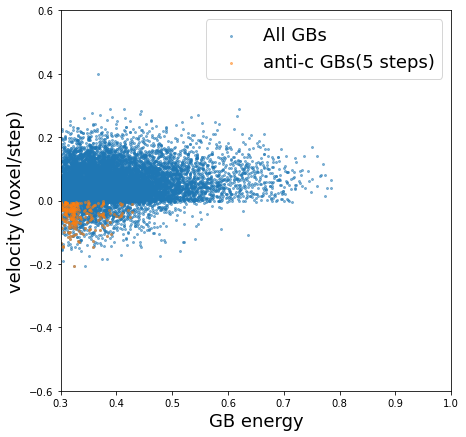

<Figure size 432x288 with 0 Axes>

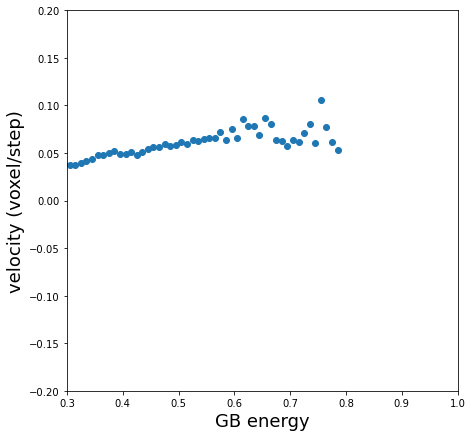

<Figure size 432x288 with 0 Axes>

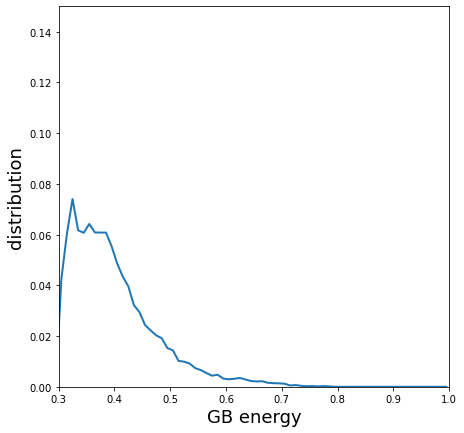

<Figure size 432x288 with 0 Axes>

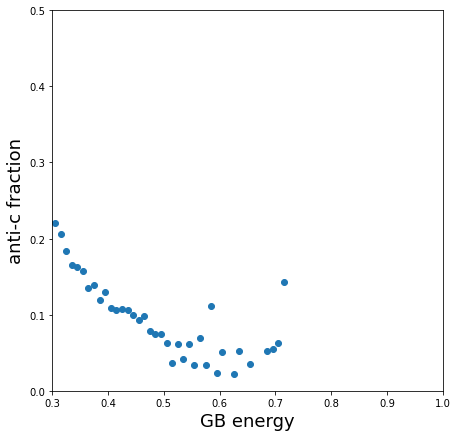

<Figure size 432x288 with 0 Axes>

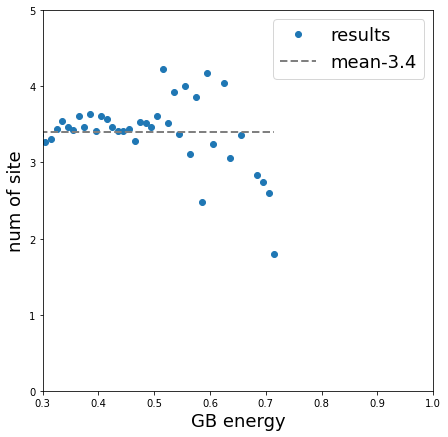

In [11]:

    figure_name_all = f"figures/2D_velocity_GBenergy_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(GBenergy_1Dlist_exrandom_remove_0step, velocity_1Dlist_exrandom_remove_0step,s=4,alpha=0.5,label='All GBs')
    GB_antic_list_GBenergy_list = np.array(GB_antic_list_GBenergy_list)
    GB_antic_list_velocity_list = np.array(GB_antic_list_velocity_list)
    GB_antic_list_anticNum_array = np.array(GB_antic_list_anticNum_list)
    plt.scatter(GB_antic_list_GBenergy_list[GB_antic_list_anticNum_array>=5], GB_antic_list_velocity_list[GB_antic_list_anticNum_array>=5],s=4,alpha=0.5,label='anti-c GBs(5 steps)')
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0.3,1.0])
    plt.ylim([-0.6,0.6])
    plt.legend(fontsize=18)
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged GBenergy
    bin_interval = 0.01
    x_lim = [0.25,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    GBenergy_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    for index in range(len(GBenergy_1Dlist_exrandom_remove_0step)):
        if abs(GBenergy_1Dlist_exrandom_remove_0step[index])>=1.0: continue
        GBenergy_bin[int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_exrandom_remove_0step[index]
        if velocity_1Dlist_exrandom_remove_0step[index] < 0: antic_num_bin[int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        if int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)<0: print(GBenergy_1Dlist_exrandom_remove_0step[index])
    for i in range(bin_number): 
        if GBenergy_bin[i]>0: velocity_bin[i] = velocity_bin[i]/GBenergy_bin[i]
    # plot
    figure_name_all_bin = f"figures/2D_velocity_GBenergy_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(GBenergy_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([0.3,1.0])
    plt.ylim([-0.2,0.2])
    plt.plot(GBenergy_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(GBenergy_bin)):
        if GBenergy_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/GBenergy_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.5])
    plt.plot(GBenergy_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("anti-c fraction", fontsize=18)
    
    anti_c_data_file_name = f"data/2D_antic_data_{case_name}"
    np.savez(anti_c_data_file_name,antic_ratio_bin=antic_ratio_bin,GBenergy_bin=GBenergy_bin)
    
    GBenergy_coordinate_larger0 = GBenergy_coordinate[antic_ratio_bin>0]
    delta_n = -0.66*np.log(antic_ratio_bin[antic_ratio_bin>0])/GBenergy_coordinate[antic_ratio_bin>0]
    mean_delta_n = np.mean(delta_n)
    mean_delta_n_2 = np.sum(delta_n*GBenergy_bin[antic_ratio_bin>0]/np.sum(GBenergy_bin[antic_ratio_bin>0]))
    print(mean_delta_n_2)
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,5])
    plt.plot(GBenergy_coordinate_larger0, delta_n,'o', linewidth=2, label = 'results')
    plt.plot(GBenergy_coordinate_larger0, mean_delta_n*np.ones(len(GBenergy_coordinate_larger0)),'--',linewidth=2,color='gray',label=f'mean-{round(mean_delta_n,2)}')
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("num of site", fontsize=18)
        


The theta is 1.7639639639639642 rads or 101.06769034830198
The radius is 1.85636344617276 and curvature is 0.5386876164049054


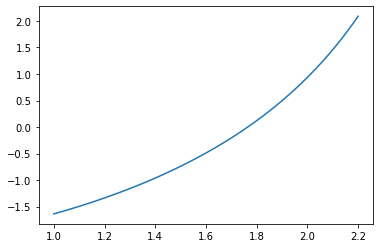

In [15]:
def equation(theta):
    return 4.5/np.sin(theta)*(1-np.cos(theta)) + 2.25/(np.sin(theta)**2)*(np.sin(theta)*np.cos(theta)-theta)

def equation2(theta,delta_site=2.6):
    diff = (9-delta_site)/2
    return 2.25/((1+np.cos(theta))**2)*(np.pi-theta+np.sin(theta)*np.cos(theta))-diff

x_list = np.linspace(1,2.2,1000)
y_list = np.zeros(100)

y_list = equation2(x_list,0.8)

plt.plot(x_list,y_list)
theta_expect = x_list[np.argmin(abs(y_list))]
print(f"The theta is {theta_expect} rads or {theta_expect/np.pi*180}")
print(f"The radius is {1.5/(1+np.cos(theta_expect))} and curvature is {(1+np.cos(theta_expect))/1.5}")

In [94]:
    # Plot relationship for each time steps
    for time_step in range(0,len(GB_list_velocity_list),10):
        figure_name = f"figures/2D_velocity_signedcurvature_MI_step{time_step}_{case_name}.png"
        plt.figure()
        fig = plt.figure(figsize=(7, 7))
        plt.scatter(GB_list_curvature_list[time_step], GB_list_velocity_list[time_step],s=4,alpha=0.5)
        plt.xlabel("curvature", fontsize=18)
        plt.ylabel("velocity (voxel/step)", fontsize=18)
        plt.xlim([-0.6,0.6])
        plt.ylim([-10,10])
        # plt.savefig(figure_name, dpi=400,bbox_inches='tight')
        
        # plot velocity VS averaged curvature
        bin_interval = 0.001
        bin_number = int(1.2/bin_interval)
        curvature_coordinate = np.arange(-0.6,0.6,bin_interval)+bin_interval/2

        curvature_bin = np.zeros(bin_number)
        velocity_bin = np.zeros(bin_number)
        for index in range(len(GB_list_curvature_list[time_step])):
            if abs(GB_list_curvature_list[time_step][index])>0.6: continue
            curvature_bin[int((GB_list_curvature_list[time_step][index]+0.6)//bin_interval)] += 1
            velocity_bin[int((GB_list_curvature_list[time_step][index]+0.6)//bin_interval)] += GB_list_velocity_list[time_step][index]
        for i in range(bin_number): 
            if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
        # plot
        figure_name_all_bin = f"figures/2D_velocity_signedcurvature_step{time_step}_{case_name}_afterBin.png"
        plt.figure()
        fig = plt.figure(figsize=(7, 7))
        # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
        plt.plot(curvature_coordinate, velocity_bin,'o', linewidth=2)
        plt.xlabel("curvature", fontsize=18)
        plt.ylabel("velocity (voxel/step)", fontsize=18)
        plt.xlim([-0.6,0.6])
        plt.ylim([-5,5])
        # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')

In [59]:
# Get more information for a focus GB

key_focus = 0
for key in tqdm(GB_id_focus):
    if GB_id_focus[key] >= 3: 
        key_focus = key

        v_focus = []
        c_focus = []
        max_step_num = 0
        max_step = []
        current_anti_step_num = 0
        current_anti_step = []
        last_curvature_value = 0
        for time_step in range(0,step_num):
            if key_focus in GB_infomation_dict_list[time_step]:
                # Calculate dV
                pair_id_pair_focus = GB_infomation_dict_list[time_step][key_focus][6:8]
                growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair_focus[0])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[1])
                growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair_focus[1])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[0])
                dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
                # Calculate velocity
                velocity = dV/time_interval/(GB_infomation_dict_list[time_step][key_focus][5]/2)
                current_curvature_value = GB_infomation_dict_list[time_step][key_focus][4]


                # store v-c for a focus GB
                v_focus.append(velocity)
                c_focus.append(current_curvature_value)

                if current_curvature_value*velocity<-0.000001 and last_curvature_value*current_curvature_value>0 and GB_infomation_dict_list[time_step][key_focus][5]>=100:
                    last_curvature_value = current_curvature_value
                    current_anti_step_num += 1
                    current_anti_step.append(time_step)
                else:
                    current_anti_step_num = 0
                    current_anti_step = []

                if current_anti_step_num > max_step_num:
                    max_step_num = current_anti_step_num
                    max_step = current_anti_step

        if max_step_num >= 3:
            print(f"The {key_focus} has long anti-c behavior with {max_step}.")






100%|██████████| 1216/1216 [16:16<00:00,  1.25it/s]


In [54]:
key_focus

45550597

The longest anti-curvature behavior is 135601364 with steps 19
The anti-curvature step 8 has velocity - -0.018 and curvature - 0.038.
The anti-curvature step 10 has velocity - -0.04 and curvature - 0.018.
The anti-curvature step 12 has velocity - -0.03 and curvature - 0.016.
The anti-curvature step 14 has velocity - -0.016 and curvature - 0.001.
The anti-curvature step 15 has velocity - -0.047 and curvature - 0.009.
The anti-curvature step 19 has velocity - -0.112 and curvature - 0.018.
The anti-curvature step 21 has velocity - -0.055 and curvature - 0.009.
The anti-curvature step 24 has velocity - -0.008 and curvature - 0.007.
The anti-curvature step 25 has velocity - -0.055 and curvature - 0.007.
The anti-curvature step 29 has velocity - -0.018 and curvature - 0.013.
The anti-curvature step 31 has velocity - -0.025 and curvature - 0.024.
The anti-curvature step 33 has velocity - -0.067 and curvature - 0.036.
The anti-curvature step 34 has velocity - -0.009 and curvature - 0.013.
The 

Text(0.5, 1.0, 'GBid 135601364 step all')

<Figure size 432x288 with 0 Axes>

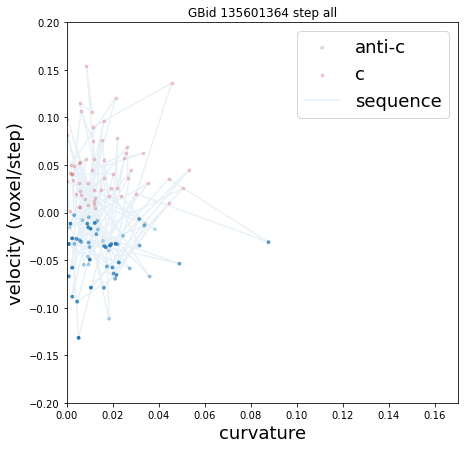

In [17]:
# Get more information for a focus GB

key_focus = 0
for key in GB_id_focus:
    if GB_id_focus[key] == 19: 
        print(f"The longest anti-curvature behavior is {key} with steps {GB_id_focus[key]}")
        key_focus = key
        # break

v_focus = []
c_focus = []
for time_step in range(0,step_num):
    if key_focus in GB_infomation_dict_list[time_step]:
        # Calculate dV
        pair_id_pair_focus = GB_infomation_dict_list[time_step][key_focus][6:8]
        growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair_focus[0])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[1])
        growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair_focus[1])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[0])
        dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
        # Calculate velocity
        velocity = dV/time_interval/(GB_infomation_dict_list[time_step][key_focus][5]/2)
        current_curvature_value = GB_infomation_dict_list[time_step][key_focus][4]
        
        # make curvature always opposite
        if current_curvature_value<0: 
            current_curvature_value = -current_curvature_value
            velocity = -velocity
        
        # store v-c for a focus GB
        v_focus.append(velocity)
        c_focus.append(current_curvature_value)
        
        if current_curvature_value*velocity<-0.00 and GB_infomation_dict_list[time_step][key_focus][5]>=100: 
            print(f"The anti-curvature step {time_step} has velocity - {round(velocity,3)} and curvature - {round(current_curvature_value,3)}.")
        
        

v_focus = np.array(v_focus)
c_focus = np.array(c_focus)
# plot v-c for a focus GB
wanted_steps = v_focus<0
alpha_list = np.linspace(0.2,1,np.sum(wanted_steps))

figure_name_one_GB = f"figures/2D_velocity_signedcurvature_{case_name}_GB{key_focus}_5d.png"
plt.figure()
fig = plt.figure(figsize=(7, 7))
import matplotlib as mpl
cmap = mpl.colormaps['tab20']
colors = cmap(np.linspace(0, 1, 20))
plt.scatter(c_focus[wanted_steps], v_focus[wanted_steps],s=8,alpha=alpha_list,color=colors[0])
plt.scatter(c_focus[~wanted_steps], v_focus[~wanted_steps],s=8,alpha=0.2,color=colors[6])
plt.plot(c_focus,v_focus,alpha=0.1)
plt.xlabel("curvature", fontsize=18)
plt.ylabel("velocity (voxel/step)", fontsize=18)
plt.xlim([0,0.17])
plt.ylim([-0.2,0.2])
plt.legend(["anti-c", "c", "sequence"],fontsize=18)
plt.title(f"GBid {key_focus} step all")
# plt.savefig(figure_name_one_GB, dpi=400,bbox_inches='tight')






In [212]:
import os
os.system(f'ffmpeg -framerate 10 -i /home/lin.yang/projects/VECTOR/examples/GB_velocity/anti_curvature_figures/Detail_2D_microstructure_key145919744_step.%04d._M_20k.png \
                    -c:v libx264 -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" -pix_fmt yuv420p \
                    anti_curvature_figures/Detail_2D_microstructure_key145919744_M_20k.mp4')

ffmpeg version 4.3.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.3.0 (GCC)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1645955405450/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1645955405450/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1645955405450/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  l

0

In [213]:
# 197673737
# 47836998
# fully 88634987
# fully 161070774
# fully 30685022
# Find the exaxt grain id and time steps
GB_id = 145919744
for time_step in range(40,step_num):
    if GB_id not in GB_infomation_dict_list[time_step]: continue
    pair_id_pair_focus = GB_infomation_dict_list[time_step][GB_id][6:8]
    break
print(f"The id pairs are {list(map(int,pair_id_pair_focus))}")

time_step_init, time_step_end = 24, 100
check_edge = 0
ss = 0
for time_step in tqdm(range(time_step_init,time_step_end)):
    current_microstructure_focus = npy_file_aniso[time_step,:,:,0]
    grain_location_focus = (current_microstructure_focus==pair_id_pair_focus[0]) + (current_microstructure_focus==pair_id_pair_focus[1])
    if check_edge ==0:
        x_info = np.arange(0,2400,1)[np.sum(grain_location_focus,0)*np.arange(0,2400,1)>0]
        x_len = np.sum(x_info>0)
        x_lim_max = int(np.max(x_info)+(x_len/2))
        x_lim_min = int(np.min(x_info)-(x_len/2))
        y_info = np.arange(0,2400,1)[np.sum(grain_location_focus,1)*np.arange(0,2400,1)>0]
        y_len = np.sum(y_info>0)
        y_lim_max = int(np.max(y_info)+y_len/2)
        y_lim_min = int(np.min(y_info)-y_len/2)
        check_edge+=1
    if np.sum(grain_location_focus)==0: continue
    current_microstructure_focus_updated = current_microstructure_focus*grain_location_focus
    
    if GB_id in GB_infomation_dict_list[time_step]:
        # Calculate velocity
        growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair_focus[0])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[1])
        growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair_focus[1])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[0])
        dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
        # Calculate velocity
        velocity = dV/time_interval/(GB_infomation_dict_list[time_step][GB_id][5]/2)
        current_curvature_value = GB_infomation_dict_list[time_step][GB_id][4]
    else:
        velocity = 0
        current_curvature_value = 0
    
    if ss<10:
        ss_char = f'0{ss}'
    else:
        ss_char = f'{ss}'
    ss+=1
    figure_name_anti_curvature_detail = figure_name_anti_curvature = f"anti_curvature_figures/Detail_2D_microstructure_key{GB_id}_step.00{ss_char}._{case_name}.png"
    plt.figure(figsize=(7,7))
    plt.imshow(current_microstructure_focus_updated,vmin=0,vmax=20000)
    plt.xlim([x_lim_min, x_lim_max])
    plt.ylim([y_lim_max, y_lim_min])
    if round(velocity,2)*round(current_curvature_value,3)<0:
        plt.title(rf"v: {round(velocity,2)} $\kappa$: {round(current_curvature_value,3)} at step {time_step}", color='orange', fontsize=16)
    else:
        plt.title(rf"v: {round(velocity,2)} $\kappa$: {round(current_curvature_value,3)} at step {time_step}", fontsize=16)
    # plt.axis("off")
    # plt.savefig(figure_name_anti_curvature_detail, dpi=400,bbox_inches='tight')

In [80]:

def energy_function_m_axis(m_polar_angle, m_azimuth_angle):
    return abs(np.cos(m_azimuth_angle)) * m_polar_angle / np.pi

def energy_function_m_axis_new(m_polar_angle, m_azimuth_angle):
    # ss = abs(np.cos(m_azimuth_angle/2)) + abs(np.cos(m_polar_angle))
    
    ss = (abs(np.cos(m_azimuth_angle/2))**0.4 + abs(np.cos(m_polar_angle))**0.4)
    if ss > 1: return 1
    else: return ss
    
    # if abs(m_azimuth_angle-np.pi) < np.pi/18 and abs(m_polar_angle - np.pi/2) < np.pi/36: return 0.0
    # else: return 1.0
    
    # return (abs(np.cos(m_azimuth_angle/2))**1.0 + abs(np.cos(m_polar_angle))**1.0)

def energy_function_m(m_polar_angle, m_azimuth_angle, m_angle):
    max_m_angle = 10/180*np.pi
    if m_angle == 0: return 0
    if m_angle>max_m_angle: m_angle=max_m_angle-0.00001
    m_angle_impact = m_angle/max_m_angle*(1-np.log(m_angle/max_m_angle))
    return energy_function_m_axis_new(m_polar_angle, m_azimuth_angle)*m_angle_impact

def energy_function_i_axis(i_polar_angle, i_azimuth_angle):
    return 0.3 + abs(np.cos(i_azimuth_angle)) * (0.7 + i_polar_angle / (np.pi/2) * (0.3 - 0.7))

def energy_function_final(m_polar_angle, m_azimuth_angle, m_angle, i_polar_angle, i_azimuth_angle):
    
    if i_polar_angle>np.pi/2: i_polar_angle = np.pi-i_polar_angle
    m_energy_impact = energy_function_m(m_polar_angle, m_azimuth_angle, m_angle)
    return 0.3 + abs(np.cos(i_azimuth_angle)) * (0.7*m_energy_impact + i_polar_angle / (np.pi/2) * (0.3*m_energy_impact - 0.7*m_energy_impact))


def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

In [79]:
# # Plot The change of inclination or misorientation in one specific GB

# # Misorientation
# init_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_multiCoreCompare/IC/"
# init_file_name = f"Case4.init"
# # misorientation calculation preparation
# grain_nums = 20000
# Osym = 24
# symm2quat_matrix, quartAngle = post_processing.pre_operation_misorientation(grain_nums, init_file_folder + init_file_name, Osym)
# print("> Pre-work done")

# misorientation = post_processing.multiP_calM(list(map(int,pair_id_pair_focus)), quartAngle, symm2quat_matrix, Osym)
# misorientation_angle = misorientation[0] # miso angle in randians
# misorientation_axis = misorientation[1:]

# # misorientation energy
# m_polar_angle = math.acos(round(misorientation_axis[2],3))
# m_azimuth_angle = math.atan2(misorientation_axis[1], misorientation_axis[0]) + np.pi
# print(f"The m-angle: {misorientation_angle/np.pi*180}, m_polar_angle: {m_polar_angle/np.pi*180}, m_azimuth_angle: {m_azimuth_angle/np.pi*180}")
# print(f"The misorientation energy: {energy_function_m(m_polar_angle, m_azimuth_angle, misorientation_angle)}")



In [78]:
# # inclination
# GB_infomation_inc_dict_list = []
# for time_step in tqdm(range(step_num)):
#     data_file_name = f"GB_velocity_data/2D_inclination_velocity_data_{case_name}_step{time_step}.npz"
#     if os.path.exists(data_file_folder + data_file_name):
#         npz_file = np.load(data_file_folder + data_file_name,allow_pickle=True)
#         GB_infomation_inc_dict = npz_file["GB_infomation_dict"]
#         GB_infomation_inc_dict_list.append(GB_infomation_inc_dict.item())
#     else:
#         print(f"Please run inclination-velocity analysis for {case_name}")
#         break

# time_interval = 30
# GB_inclination_energy_list = []
# GB_final_energy_list = []
# GB_velocity_list = []
# for time_step in range(step_num):
#     if time_step+1 >= step_num: continue
#     if key_focus not in GB_infomation_inc_dict_list[time_step]: continue
#     if GB_infomation_inc_dict_list[time_step+1].get(key_focus) is None: continue
#     # Calculate volumn change
#     growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair_focus[0])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[1])
#     growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair_focus[1])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[0])
#     dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
#     # Calculate velocity
#     velocity = dV/time_interval/(GB_infomation_inc_dict_list[time_step][key_focus][6]/2)
#     # change velocity sign with curvature
#     current_curvature_value = GB_infomation_dict_list[time_step][key_focus][4]
#     # make curvature always opposite
#     if current_curvature_value<0: 
#         current_curvature_value = -current_curvature_value
#         velocity = -velocity
    
#     GB_velocity_list.append(velocity)

#     # Get inclination
#     DX, DY = GB_infomation_inc_dict_list[time_step][key_focus][4:6]
#     vec_len = np.sqrt(DX**2+DY**2)
#     if vec_len==0: dx, dy = 0, 0
#     else: dx, dy = -DX/vec_len, DY/vec_len # the process just repeated get_grad(P,i,j) in myInput.py 
#     dz = 0
#     dy = -dy # Update the issue in VECTOR
#     inclination = np.array([dx,dy,dz])
#     # Get misorientation
#     # rotate misorientation axis to z axis, and incliantion to final vector
#     z_axis = np.array([0,0,1])
#     rotation_matrix_m_axis_to_z_axis = rotation_matrix_from_vectors(misorientation_axis, z_axis)
#     incliantion_refer_m_axis = rotation_matrix_m_axis_to_z_axis.dot(inclination)
#     # Get polar and azimuth dsitribution
#     i_polar_angle = math.acos(round(incliantion_refer_m_axis[2],3))
#     i_azimuth_angle = math.atan2(incliantion_refer_m_axis[1], incliantion_refer_m_axis[0]) + np.pi
    
#     # inclination energy
#     inclination_energy = energy_function_i_axis(i_polar_angle, i_azimuth_angle)
#     final_energy = energy_function_final(m_polar_angle, m_azimuth_angle, misorientation_angle, i_polar_angle, i_azimuth_angle)
#     GB_inclination_energy_list.append(inclination_energy)
#     GB_final_energy_list.append(final_energy)
#     # print(inclination_energy)
#     # print(final_energy)
#     # print()




In [77]:

# GB_inclination_energy_list = np.array(GB_inclination_energy_list)
# GB_velocity_list = np.array(GB_velocity_list)
# GB_final_energy_list = np.array(GB_final_energy_list)

# wanted_steps = GB_velocity_list<0
# alpha_list = np.linspace(0.2,1,np.sum(wanted_steps))
# figure_name_one_GB = f"figures/2D_velocity_inclinationE_{case_name}_GB{key_focus}_5d.png"
# plt.figure()
# fig = plt.figure(figsize=(7, 7))
# import matplotlib as mpl
# cmap = mpl.colormaps['tab20']
# colors = cmap(np.linspace(0, 1, 20))
# plt.scatter(GB_inclination_energy_list[wanted_steps], GB_velocity_list[wanted_steps],s=8,alpha=alpha_list,c=colors[0])
# plt.scatter(GB_inclination_energy_list[~wanted_steps], GB_velocity_list[~wanted_steps],s=8,alpha=0.2,c=colors[6])
# plt.plot(GB_inclination_energy_list,GB_velocity_list,alpha=0.1)
# plt.xlabel("inclination energy", fontsize=18)
# plt.ylabel("velocity (voxel/step)", fontsize=18)
# # plt.xlim([0.334,0.35])
# plt.ylim([-0.2,0.2])
# plt.legend(["anti-c", "c", "sequence"],fontsize=18)
# plt.title(f"GBid {key_focus} step all")
# # plt.savefig(figure_name_one_GB, dpi=400,bbox_inches='tight')

## TJ study


In [12]:
#     # GB_id_unfocus_lowE_detail and GB_id_focus_detail
    
#     # reorginaize the data structure for GB_id_unfocus_lowE_detail and GB_id_focus_detail
#     GB_id_unfocus_lowE_detail_time = dict()
#     GB_id_focus_detail_time = dict()
#     for key in GB_id_unfocus_lowE_detail:
#         for key_time in GB_id_unfocus_lowE_detail[key]:
#             if key_time in GB_id_unfocus_lowE_detail_time:
#                 GB_id_unfocus_lowE_detail_time[key_time].append(key)
#             else: 
#                 GB_id_unfocus_lowE_detail_time[key_time] = [key]
                
#     for key in GB_id_focus_detail:
#         for key_time in GB_id_focus_detail[key]:
#             if key_time in GB_id_focus_detail_time:
#                 GB_id_focus_detail_time[key_time].append(key)
#             else:
#                 GB_id_focus_detail_time[key_time] = [key]

In [38]:
    # GB_id_unfocus_lowE_detail and GB_id_focus_detail
    
    # reorginaize the data structure for GB_id_unfocus_lowE_detail and GB_id_focus_detail
    GB_id_unfocus_lowE_detail_time = dict()
    GB_id_focus_detail_time = dict()
    for key in GB_id_unfocus_lowE_detail:
        for key_time in GB_id_unfocus_lowE_detail[key]:
            if key_time in GB_id_unfocus_lowE_detail_time:
                GB_id_unfocus_lowE_detail_time[key_time].append(key)
            else: 
                GB_id_unfocus_lowE_detail_time[key_time] = [key]
                
    for key in GB_id_focus_detail:
        for key_time in GB_id_focus_detail[key]:
            if key_time in GB_id_focus_detail_time:
                GB_id_focus_detail_time[key_time].append(key)
            else:
                GB_id_focus_detail_time[key_time] = [key]
            
            
    # find the TJ around GB with anti-c behavior or low energy c behavior 
    site_energy_per_unit_focus_list = []
    site_energy_per_unit_unfocus_list = []
    for time_step in tqdm(range(step_num)):
        
        if time_step not in GB_id_focus_detail_time: current_focus_GB_id = []
        else: current_focus_GB_id = GB_id_focus_detail_time[time_step]
        if time_step not in GB_id_unfocus_lowE_detail_time: current_unfocus_GB_id = []
        else: current_unfocus_GB_id = GB_id_unfocus_lowE_detail_time[time_step]
        if len(current_focus_GB_id) == 0 and len(current_unfocus_GB_id) == 0: continue
        # current_GB_id = []
        # current_GB_id.extend(current_focus_GB_id)
        # current_GB_id.extend(current_unfocus_GB_id)
        current_microstructure = npy_file_aniso[time_step]
        current_energy = npy_file_aniso_energy[time_step]
        
        

        
        size_x, size_y = npy_file_aniso[time_step].shape[0:2]
        k=0
        for i in range(size_x):
            for j in range(size_y):

                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                # find window and jump over GB and grain bulk
                neighboring_sites_full_list = np.array([current_microstructure[i,j,k], current_microstructure[ip,jp,k], current_microstructure[ip,j,k], current_microstructure[ip,jm,k], current_microstructure[i,jp,k], current_microstructure[i,jm,k], current_microstructure[im,jp,k], current_microstructure[im,j,k], current_microstructure[im,jm,k]]).astype(int)
                grain_id_num_in_window = np.unique(neighboring_sites_full_list)
                if len(grain_id_num_in_window) < 3: continue
                
                # 
                do_you_find = 0
                for current_key in current_focus_GB_id:
                    pair_id_pair_focus = GB_infomation_dict_list[time_step][current_key][6:8]
                    if pair_id_pair_focus[0] in grain_id_num_in_window and pair_id_pair_focus[0] in grain_id_num_in_window:
                        # do 
                        site_energy = current_energy[i,j,k]
                        num_nei = 0
                        for nei in neighboring_sites_full_list[1:]:
                            if neighboring_sites_full_list[0] != nei: num_nei += 1
                        site_energy_per_unit_focus_list.append(site_energy/num_nei)
                        do_you_find += 1
                        break
                if do_you_find > 0: continue
                for current_key in current_unfocus_GB_id:
                    pair_id_pair_focus = GB_infomation_dict_list[time_step][current_key][6:8]
                    if pair_id_pair_focus[0] in grain_id_num_in_window and pair_id_pair_focus[0] in grain_id_num_in_window:
                        # do 
                        site_energy = current_energy[i,j,k]
                        num_nei = 0
                        for nei in neighboring_sites_full_list[1:]:
                            if neighboring_sites_full_list[0] != nei: num_nei += 1
                        site_energy_per_unit_unfocus_list.append(site_energy/num_nei)
                        break
                        
                
    xLim = [0,2.0]
    binValue = 0.01001
    binNum = round((abs(xLim[0])+abs(xLim[1]))/binValue)
    xCor = np.linspace((xLim[0]+binValue/2),(xLim[1]-binValue/2),binNum)
    freqArray_focus = np.zeros(binNum)
    freqArray_unfocus = np.zeros(binNum)

    for i in range(len(site_energy_per_unit_focus_list)): freqArray_focus[int((site_energy_per_unit_focus_list[i] - xCor[0]) / binValue)] += 1
    for i in range(len(site_energy_per_unit_unfocus_list)): freqArray_unfocus[int((site_energy_per_unit_unfocus_list[i] - xCor[0]) / binValue)] += 1
        
            
            
            

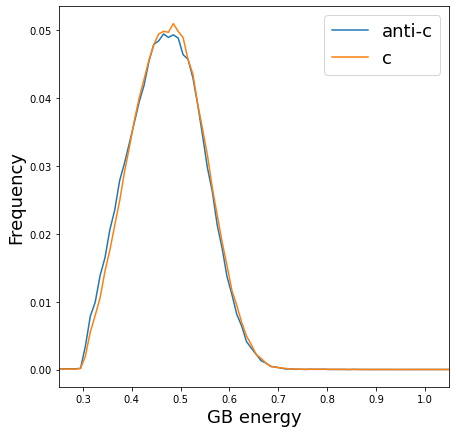

In [83]:
    freqArray_focus = freqArray_focus/np.sum(freqArray_focus)
    freqArray_unfocus = freqArray_unfocus/np.sum(freqArray_unfocus)

    plt.figure(figsize=(7,7))
    plt.plot(xCor, freqArray_focus, label='anti-c')
    plt.plot(xCor, freqArray_unfocus, label='c')
    plt.xlim([0.25,1.05])
    # plt.ylim([-0.15,0.15])
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("Frequency", fontsize=18)
    plt.legend(fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')


## TJ movement

In [13]:
    # GB_id_unfocus_lowE_detail and GB_id_focus_detail
    # Compare the TJ movement around anti-c GBs and all TJ movement
            
    # TJ information
    step_num = 121
    TJ_information_dict_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name_TJ = f"GB_velocity_data/2D_TJ_information_data_{case_name}_step{time_step}.npz"
        
        if os.path.exists(data_file_folder + data_file_name_TJ):
            npz_file = np.load(data_file_folder + data_file_name_TJ,allow_pickle=True)
            TJ_information_dict = npz_file["TJ_information_dict"]
            TJ_information_dict_list.append(TJ_information_dict.item())
        else:
            TJ_information_dict = dict()
            current_microstructure = npy_file_aniso[time_step]
            current_energy = npy_file_aniso_energy[time_step]

            size_x, size_y = npy_file_aniso[time_step].shape[0:2]
            k=0
            for i in range(size_x):
                for j in range(size_y):
                    ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                    # find window and jump over GB and grain bulk
                    neighboring_sites_full_list = np.array([current_microstructure[i,j,k], current_microstructure[ip,jp,k], current_microstructure[ip,j,k], current_microstructure[ip,jm,k], current_microstructure[i,jp,k], current_microstructure[i,jm,k], current_microstructure[im,jp,k], current_microstructure[im,j,k], current_microstructure[im,jm,k]]).astype(int)
                    # neighboring_sites_full_list = np.array([current_microstructure[i,j,k], current_microstructure[ip,jp,k], current_microstructure[ip,j,k], current_microstructure[i,jp,k]]).astype(int)
                    grain_id_num_in_window = np.unique(neighboring_sites_full_list) # the result is in order [1,2,3]
                    TJ_key_tuple = tuple(grain_id_num_in_window)
                    if len(grain_id_num_in_window) != 3: continue # jump over GBs and bulks and QJs

                    # keep TJ information
                    if TJ_key_tuple in TJ_information_dict:
                        # take the voxel on the edge into account
                        known_location = TJ_information_dict[TJ_key_tuple][:3]/TJ_information_dict[TJ_key_tuple][4]
                        current_location = np.array([i,j,k])
                        location_distance = known_location-current_location
                        location_distance_bool = abs(location_distance)>size_x/2
                        if np.sum(location_distance_bool)>0: 
                            i_new,j_new,k_new = current_location + (location_distance*location_distance_bool>0)*size_x+(location_distance*location_distance_bool<0)*-size_x
                            TJ_information_dict[TJ_key_tuple] += np.array([i_new,j_new,k_new, current_energy[i,j,k], 1])
                        else: 
                            TJ_information_dict[TJ_key_tuple] += np.array([i,j,k, current_energy[i,j,k], 1])
                    else:
                        TJ_information_dict[TJ_key_tuple] = np.array([i,j,k, current_energy[i,j,k], 1]) # i,j,k,TJenergy,TJnum
            # finish the normalize
            for TJ_key in TJ_information_dict:
                TJ_information_dict[TJ_key][:4] = TJ_information_dict[TJ_key][:4]/TJ_information_dict[TJ_key][4]
                if np.sum(TJ_information_dict[TJ_key][:3] < 0):
                    TJ_information_dict[TJ_key][:3] = TJ_information_dict[TJ_key][:3] + (TJ_information_dict[TJ_key][:3] < 0)*size_x
                elif np.sum(TJ_information_dict[TJ_key][:3] >size_x):
                    TJ_information_dict[TJ_key][:3] = TJ_information_dict[TJ_key][:3] + (TJ_information_dict[TJ_key][:3] < 0)*-size_x
            
            print(f"TJs in {time_step} step is {len(TJ_information_dict)}")
            wierd_TJ = 0
            for TJ_info in TJ_information_dict.values():
                if TJ_info[4] < 4: wierd_TJ+=1
            print(f"Weird TJs is {wierd_TJ}")
            # save information
            np.savez(data_file_folder + data_file_name_TJ, TJ_information_dict=TJ_information_dict)
            TJ_information_dict_list.append(TJ_information_dict)

            

100%|██████████| 121/121 [00:02<00:00, 49.12it/s] 


In [48]:
    # extract TJ velocity
    time_interval = 30
    TJ_velocity_list = []
    TJ_velocity_1Dlist = []
    TJ_focus_velocity_list = []
    TJ_focus_velocity_1Dlist = []
    TJ_energy_list = []
    TJ_energy_1Dlist = []
    TJ_focus_energy_list = []
    TJ_focus_energy_1Dlist = []
    TJ_GBenergy_list = []
    TJ_GBenergy_1Dlist = []
    TJ_GBenergy_1Dlist_three = [[],[],[]]
    TJ_GBenergy_1Dlist_diff_three = [[],[],[]]
    TJ_focus_GBenergy_list = []
    TJ_focus_GBenergy_1Dlist = []
    TJ_focus_GBenergy_1Dlist_three = [[],[],[]]
    TJ_focus_GBenergy_1Dlist_diff_three = [[],[],[]]
    # dict for GB
    GB_with_four_GBenergy_diff = dict()
    GB_focus_with_four_GBenergy_diff = dict()
    for time_step in range(step_num):
        if time_step + 1 >= step_num: continue
        TJ_velocity_list_tmp = []
        TJ_energy_list_tmp = []
        TJ_focus_velocity_list_tmp = []
        TJ_focus_energy_list_tmp = []
        TJ_GBenergy_list_tmp = []
        TJ_GBenergy_list_three_tmp = []
        TJ_focus_GBenergy_list_tmp = []
        TJ_focus_GBenergy_list_three_tmp = []
        for TJ_key in tqdm(TJ_information_dict_list[time_step]):
            if TJ_information_dict_list[time_step+1].get(TJ_key) is None: continue
            edge_matrix = np.array([[size_x,0,0],[-size_x,0,0],[0,size_y,0],[0,-size_y,0],[size_x,size_y,0],[-size_x,-size_y,0],[-size_x,size_y,0],[size_x,-size_y,0]])
            
            # calculate three GB energy
            GB_key1_at_TJ = post_processing.get_line(TJ_key[0],TJ_key[1])
            GB_key2_at_TJ = post_processing.get_line(TJ_key[0],TJ_key[2])
            GB_key3_at_TJ = post_processing.get_line(TJ_key[1],TJ_key[2])
            if (GB_key1_at_TJ in GBenergy_information_dict_list[time_step] and
                GB_key2_at_TJ in GBenergy_information_dict_list[time_step] and
                GB_key3_at_TJ in GBenergy_information_dict_list[time_step]):
                
                GB_key1_energy = GBenergy_information_dict_list[time_step][GB_key1_at_TJ][4]
                GB_key2_energy = GBenergy_information_dict_list[time_step][GB_key2_at_TJ][4]
                GB_key3_energy = GBenergy_information_dict_list[time_step][GB_key3_at_TJ][4]
                GB_3keys_energy = [GB_key1_energy,GB_key2_energy,GB_key3_energy]
                GB_3keys_energy_left = [GB_key2_energy,GB_key3_energy,GB_key1_energy]
                GB_3keys_energy.sort()
                TJ_GBenergy_list_tmp.extend(GB_3keys_energy)
                TJ_GBenergy_1Dlist_three[0].append(GB_3keys_energy[0])
                TJ_GBenergy_1Dlist_three[1].append(GB_3keys_energy[1])
                TJ_GBenergy_1Dlist_three[2].append(GB_3keys_energy[2])
                GB_3diff_energy = abs(np.array(GB_3keys_energy_left) - np.array(GB_3keys_energy))
                TJ_GBenergy_1Dlist_diff_three[0].append(np.mean(GB_3diff_energy)) # ave
                TJ_GBenergy_1Dlist_diff_three[1].append(np.min(GB_3diff_energy)) # min
                TJ_GBenergy_1Dlist_diff_three[2].append(np.max(GB_3diff_energy)) # max
                
                # keep four GB energy diff for each GB
                for current_index, current_GB_key in enumerate([GB_key1_at_TJ,GB_key2_at_TJ,GB_key3_at_TJ]):
                    keep_energy_three = abs(np.array(GB_3keys_energy)-GB_3keys_energy[current_index])
                    keep_energy_two = np.delete(keep_energy_three, [current_index])
                    if (time_step,current_GB_key) in GB_with_four_GBenergy_diff:
                        GB_with_four_GBenergy_diff[(time_step,current_GB_key)].extend(list(keep_energy_two))
                        GB_with_four_GBenergy_diff[(time_step,current_GB_key)].extend([abs(keep_energy_two[1]-keep_energy_two[0])]) # add the third value for GB specific
                    else: 
                        GB_with_four_GBenergy_diff[(time_step,current_GB_key)] = list(keep_energy_two)
                        GB_with_four_GBenergy_diff[(time_step,current_GB_key)].extend([abs(keep_energy_two[1]-keep_energy_two[0])]) # add the third value for GB specific
                
                
            
            # get two points location
            location_next_step = TJ_information_dict_list[time_step+1][TJ_key][:3]
            location_current = TJ_information_dict_list[time_step][TJ_key][:3]
            # get distance between two points, "not in edge" and "in edge" cases
            if np.linalg.norm(location_next_step-location_current) < size_x/10:
                distance = np.linalg.norm(location_next_step-location_current)
            else:
                difference_8points = np.tile(location_next_step,(8,1)) + edge_matrix - np.tile(location_current,(8,1))
                distance_8points = np.linalg.norm(difference_8points,axis=1)
                distance = np.min(distance_8points)
            # calculate velocity
            velocity = distance / time_interval
            TJ_velocity_list_tmp.append(velocity)
            # TJ averaged energy
            TJ_energy = TJ_information_dict_list[time_step][TJ_key][3]
            TJ_energy_list_tmp.append(TJ_energy)
            
            # consider the TJ around the anti-c GB
            if time_step not in GB_id_focus_detail_time: continue
            else: current_focus_GB_id = GB_id_focus_detail_time[time_step]
            for GB_key in current_focus_GB_id:
                pair_id_pair_focus = GB_infomation_dict_list[time_step][GB_key][6:8]
                # We take the difference of two other GB and anti-c GB into account
                
#                 if pair_id_pair_focus[0] in TJ_key and pair_id_pair_focus[1] in TJ_key:
#                     # current TJ is around anti-c GB
#                     TJ_focus_velocity_list_tmp.append(velocity)
#                     TJ_focus_energy_list_tmp.append(TJ_energy)
                    
#                     # get the third grain id
#                     for grain_id in TJ_key:
#                         if grain_id not in pair_id_pair_focus:
#                             grain_id_third_grain = grain_id
                    
#                     # get the velocity direction
#                     growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair_focus[0])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[1])
#                     growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair_focus[1])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[0])
#                     dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
#                     velocity = dV/time_interval/(GB_infomation_dict_list[time_step][GB_key][5]/2) # 1 direction get negative, 0 get positive
#                     # Get the GB key same as velocity direction and opposite to v direciton
#                     if velocity>0:
#                         GB_key_positive_velocity = post_processing.get_line(pair_id_pair_focus[0],grain_id_third_grain)
#                         GB_key_negative_velocity = post_processing.get_line(pair_id_pair_focus[1],grain_id_third_grain)
#                     else:
#                         GB_key_positive_velocity = post_processing.get_line(pair_id_pair_focus[1],grain_id_third_grain)
#                         GB_key_negative_velocity = post_processing.get_line(pair_id_pair_focus[0],grain_id_third_grain)
                        
#                     if (GB_key_positive_velocity in GBenergy_information_dict_list[time_step] and
#                         GB_key_negative_velocity in GBenergy_information_dict_list[time_step] and
#                         GB_key in GBenergy_information_dict_list[time_step]):    
#                         TJ_focus_GBenergy_list_tmp.extend(GB_3keys_energy) # old information
                    
#                         # get the energy for the two GB keys
#                         GB_key_pv_energy = GBenergy_information_dict_list[time_step][GB_key_positive_velocity][4]
#                         GB_key_nv_energy = GBenergy_information_dict_list[time_step][GB_key_negative_velocity][4]
#                         GB_antic_energy = GBenergy_information_dict_list[time_step][GB_key][4]
#                         # keep
#                         TJ_focus_GBenergy_1Dlist_two[0].append(GB_key_pv_energy-GB_antic_energy)
#                         TJ_focus_GBenergy_1Dlist_two[1].append(GB_key_nv_energy-GB_antic_energy)
                    
#                     break # because each TJ will have maximum of one anti-c GB
                
                
                
                if pair_id_pair_focus[0] in TJ_key and pair_id_pair_focus[1] in TJ_key:
                    # current TJ is around anti-c GB
                    TJ_focus_velocity_list_tmp.append(velocity)
                    TJ_focus_energy_list_tmp.append(TJ_energy)
                    # calculate three GB energy
                    if (GB_key1_at_TJ in GBenergy_information_dict_list[time_step] and
                        GB_key2_at_TJ in GBenergy_information_dict_list[time_step] and
                        GB_key3_at_TJ in GBenergy_information_dict_list[time_step]):
                        TJ_focus_GBenergy_list_tmp.extend(GB_3keys_energy)
                        TJ_focus_GBenergy_1Dlist_three[0].append(GB_3keys_energy[0])
                        TJ_focus_GBenergy_1Dlist_three[1].append(GB_3keys_energy[1])
                        TJ_focus_GBenergy_1Dlist_three[2].append(GB_3keys_energy[2])
                        TJ_focus_GBenergy_1Dlist_diff_three[0].append(np.mean(GB_3diff_energy)) # ave
                        TJ_focus_GBenergy_1Dlist_diff_three[1].append(np.min(GB_3diff_energy)) # min
                        TJ_focus_GBenergy_1Dlist_diff_three[2].append(np.max(GB_3diff_energy)) # max
                        
                        # keep four GB energy difference on anti-c GB
                        GB_focus_with_four_GBenergy_diff[(time_step,GB_key)] = GB_with_four_GBenergy_diff[(time_step,GB_key)]
                    break
            
        
        print(f"All TJs in {time_step} step is {len(TJ_velocity_list_tmp)}, focused TJs is {len(TJ_focus_velocity_list_tmp)}")
        TJ_velocity_list.append(TJ_velocity_list_tmp)
        TJ_velocity_1Dlist.extend(TJ_velocity_list_tmp)
        TJ_focus_velocity_list.append(TJ_focus_velocity_list_tmp)
        TJ_focus_velocity_1Dlist.extend(TJ_focus_velocity_list_tmp)
        TJ_energy_list.append(TJ_energy_list_tmp)
        TJ_energy_1Dlist.extend(TJ_energy_list_tmp)
        TJ_focus_energy_list.append(TJ_focus_energy_list_tmp)
        TJ_focus_energy_1Dlist.extend(TJ_focus_energy_list_tmp)
        TJ_GBenergy_list.append(TJ_GBenergy_list_tmp)
        TJ_GBenergy_1Dlist.extend(TJ_GBenergy_list_tmp)
        TJ_focus_GBenergy_list.append(TJ_focus_GBenergy_list_tmp)
        TJ_focus_GBenergy_1Dlist.extend(TJ_focus_GBenergy_list_tmp)
        
    # clean the data for four GB energy on GB object
    GB_four_GBenergy_values = list(GB_with_four_GBenergy_diff.values())
    GB_focus_four_GBenergy_values = list(GB_focus_with_four_GBenergy_diff.values())
    GB_four_GBenergy_values_update = []
    GB_focus_four_GBenergy_values_update = []
    for i in range(len(GB_four_GBenergy_values)):
        if len(GB_four_GBenergy_values[i]) == 6: GB_four_GBenergy_values_update.append(GB_four_GBenergy_values[i])
    for i in range(len(GB_focus_four_GBenergy_values)):
        if len(GB_focus_four_GBenergy_values[i]) == 6: GB_focus_four_GBenergy_values_update.append(GB_focus_four_GBenergy_values[i])
    # only keep ave min max for it
    TJ_GBenergy_1Dlist_diff_four = [[],[],[]]
    TJ_GBenergy_1Dlist_diff_four_all = []
    TJ_focus_GBenergy_1Dlist_diff_four = [[],[],[]]
    TJ_focus_GBenergy_1Dlist_diff_four_all = []
    for i in range(len(GB_four_GBenergy_values_update)):
        TJ_GBenergy_1Dlist_diff_four[0].append(np.mean(GB_four_GBenergy_values_update[i]))
        TJ_GBenergy_1Dlist_diff_four[1].append(np.min(GB_four_GBenergy_values_update[i]))
        TJ_GBenergy_1Dlist_diff_four[2].append(np.max(GB_four_GBenergy_values_update[i]))
        TJ_GBenergy_1Dlist_diff_four_all.extend(GB_four_GBenergy_values_update[i])
    for i in range(len(GB_focus_four_GBenergy_values_update)):
        TJ_focus_GBenergy_1Dlist_diff_four[0].append(np.mean(GB_focus_four_GBenergy_values_update[i]))
        TJ_focus_GBenergy_1Dlist_diff_four[1].append(np.min(GB_focus_four_GBenergy_values_update[i]))
        TJ_focus_GBenergy_1Dlist_diff_four[2].append(np.max(GB_focus_four_GBenergy_values_update[i]))
        TJ_focus_GBenergy_1Dlist_diff_four_all.extend(GB_focus_four_GBenergy_values_update[i])
    


        

100%|██████████| 41448/41448 [00:00<00:00, 159699.05it/s]


All TJs in 0 step is 11563, focused TJs is 0


100%|██████████| 27217/27217 [00:00<00:00, 87531.28it/s]


All TJs in 1 step is 9291, focused TJs is 0


100%|██████████| 18768/18768 [00:00<00:00, 47629.27it/s]


All TJs in 2 step is 8544, focused TJs is 6


100%|██████████| 14209/14209 [00:00<00:00, 30159.21it/s]


All TJs in 3 step is 7757, focused TJs is 24


100%|██████████| 11461/11461 [00:00<00:00, 21196.44it/s]


All TJs in 4 step is 6722, focused TJs is 54


100%|██████████| 9538/9538 [00:00<00:00, 16556.36it/s]


All TJs in 5 step is 6116, focused TJs is 79


100%|██████████| 8145/8145 [00:00<00:00, 14524.92it/s]


All TJs in 6 step is 5675, focused TJs is 85


100%|██████████| 7179/7179 [00:00<00:00, 11975.74it/s]


All TJs in 7 step is 5204, focused TJs is 119


100%|██████████| 6409/6409 [00:00<00:00, 11683.44it/s]


All TJs in 8 step is 4820, focused TJs is 122


100%|██████████| 5813/5813 [00:00<00:00, 11134.91it/s]


All TJs in 9 step is 4400, focused TJs is 137


100%|██████████| 5274/5274 [00:00<00:00, 11497.32it/s]


All TJs in 10 step is 4177, focused TJs is 102


100%|██████████| 4857/4857 [00:00<00:00, 9744.92it/s]


All TJs in 11 step is 3890, focused TJs is 147


100%|██████████| 4484/4484 [00:00<00:00, 6947.26it/s] 


All TJs in 12 step is 3658, focused TJs is 108


100%|██████████| 4189/4189 [00:00<00:00, 9913.37it/s]


All TJs in 13 step is 3461, focused TJs is 132


100%|██████████| 3896/3896 [00:00<00:00, 9557.59it/s]


All TJs in 14 step is 3255, focused TJs is 136


100%|██████████| 3665/3665 [00:00<00:00, 9954.62it/s]


All TJs in 15 step is 3112, focused TJs is 125


100%|██████████| 3449/3449 [00:00<00:00, 9708.29it/s]


All TJs in 16 step is 2983, focused TJs is 123


100%|██████████| 3293/3293 [00:00<00:00, 10151.79it/s]


All TJs in 17 step is 2781, focused TJs is 105


100%|██████████| 3116/3116 [00:00<00:00, 10304.60it/s]


All TJs in 18 step is 2671, focused TJs is 110


100%|██████████| 2950/2950 [00:00<00:00, 9603.23it/s]


All TJs in 19 step is 2593, focused TJs is 117


100%|██████████| 2829/2829 [00:00<00:00, 9642.52it/s]


All TJs in 20 step is 2476, focused TJs is 123


100%|██████████| 2699/2699 [00:00<00:00, 9544.79it/s]


All TJs in 21 step is 2374, focused TJs is 117


100%|██████████| 2594/2594 [00:00<00:00, 8545.43it/s]


All TJs in 22 step is 2272, focused TJs is 149


100%|██████████| 2473/2473 [00:00<00:00, 9197.56it/s]


All TJs in 23 step is 2241, focused TJs is 114


100%|██████████| 2401/2401 [00:00<00:00, 9172.02it/s]


All TJs in 24 step is 2119, focused TJs is 113


100%|██████████| 2307/2307 [00:00<00:00, 9342.68it/s]


All TJs in 25 step is 2070, focused TJs is 110


100%|██████████| 2229/2229 [00:00<00:00, 9391.93it/s]


All TJs in 26 step is 1988, focused TJs is 104


100%|██████████| 2157/2157 [00:00<00:00, 9047.57it/s]


All TJs in 27 step is 1933, focused TJs is 121


100%|██████████| 2084/2084 [00:00<00:00, 9689.88it/s]


All TJs in 28 step is 1846, focused TJs is 99


100%|██████████| 2000/2000 [00:00<00:00, 9328.70it/s]


All TJs in 29 step is 1803, focused TJs is 106


100%|██████████| 1921/1921 [00:00<00:00, 8638.41it/s]


All TJs in 30 step is 1758, focused TJs is 123


100%|██████████| 1874/1874 [00:00<00:00, 9279.74it/s]


All TJs in 31 step is 1686, focused TJs is 105


100%|██████████| 1800/1800 [00:00<00:00, 8627.70it/s]


All TJs in 32 step is 1650, focused TJs is 123


100%|██████████| 1749/1749 [00:00<00:00, 9928.19it/s]


All TJs in 33 step is 1588, focused TJs is 76


100%|██████████| 1703/1703 [00:00<00:00, 8641.41it/s]


All TJs in 34 step is 1579, focused TJs is 109


100%|██████████| 1679/1679 [00:00<00:00, 9370.57it/s]


All TJs in 35 step is 1566, focused TJs is 90


100%|██████████| 1648/1648 [00:00<00:00, 9367.51it/s]


All TJs in 36 step is 1516, focused TJs is 85


100%|██████████| 1598/1598 [00:00<00:00, 9582.99it/s]


All TJs in 37 step is 1479, focused TJs is 75


100%|██████████| 1565/1565 [00:00<00:00, 9851.90it/s]


All TJs in 38 step is 1442, focused TJs is 71


100%|██████████| 1520/1520 [00:00<00:00, 9712.13it/s]


All TJs in 39 step is 1399, focused TJs is 71


100%|██████████| 1473/1473 [00:00<00:00, 9147.09it/s]


All TJs in 40 step is 1361, focused TJs is 90


100%|██████████| 1441/1441 [00:00<00:00, 9740.60it/s]


All TJs in 41 step is 1341, focused TJs is 66


100%|██████████| 1409/1409 [00:00<00:00, 10016.84it/s]


All TJs in 42 step is 1290, focused TJs is 73


100%|██████████| 1379/1379 [00:00<00:00, 9644.35it/s]


All TJs in 43 step is 1289, focused TJs is 66


100%|██████████| 1354/1354 [00:00<00:00, 9714.87it/s]


All TJs in 44 step is 1256, focused TJs is 66


100%|██████████| 1324/1324 [00:00<00:00, 9770.24it/s]


All TJs in 45 step is 1253, focused TJs is 72


100%|██████████| 1299/1299 [00:00<00:00, 9636.91it/s]


All TJs in 46 step is 1225, focused TJs is 69


100%|██████████| 1279/1279 [00:00<00:00, 8827.85it/s]


All TJs in 47 step is 1195, focused TJs is 84


100%|██████████| 1252/1252 [00:00<00:00, 9173.87it/s]


All TJs in 48 step is 1179, focused TJs is 77


100%|██████████| 1230/1230 [00:00<00:00, 9572.47it/s]


All TJs in 49 step is 1153, focused TJs is 74


100%|██████████| 1205/1205 [00:00<00:00, 9875.99it/s]


All TJs in 50 step is 1140, focused TJs is 65


100%|██████████| 1185/1185 [00:00<00:00, 9540.69it/s]


All TJs in 51 step is 1134, focused TJs is 66


100%|██████████| 1178/1178 [00:00<00:00, 9388.69it/s]


All TJs in 52 step is 1098, focused TJs is 84


100%|██████████| 1146/1146 [00:00<00:00, 9351.81it/s]


All TJs in 53 step is 1078, focused TJs is 65


100%|██████████| 1130/1130 [00:00<00:00, 9480.55it/s]


All TJs in 54 step is 1047, focused TJs is 77


100%|██████████| 1103/1103 [00:00<00:00, 10150.49it/s]


All TJs in 55 step is 1041, focused TJs is 56


100%|██████████| 1083/1083 [00:00<00:00, 9655.65it/s]


All TJs in 56 step is 1019, focused TJs is 58


100%|██████████| 1064/1064 [00:00<00:00, 9982.64it/s] 


All TJs in 57 step is 1026, focused TJs is 49


100%|██████████| 1055/1055 [00:00<00:00, 9786.73it/s]


All TJs in 58 step is 1004, focused TJs is 54


100%|██████████| 1038/1038 [00:00<00:00, 2596.34it/s]


All TJs in 59 step is 978, focused TJs is 66


100%|██████████| 1021/1021 [00:00<00:00, 10668.81it/s]


All TJs in 60 step is 963, focused TJs is 51


100%|██████████| 1007/1007 [00:00<00:00, 10106.18it/s]


All TJs in 61 step is 941, focused TJs is 50


100%|██████████| 985/985 [00:00<00:00, 10107.18it/s]


All TJs in 62 step is 915, focused TJs is 52


100%|██████████| 959/959 [00:00<00:00, 8895.28it/s]


All TJs in 63 step is 940, focused TJs is 75


100%|██████████| 954/954 [00:00<00:00, 9465.80it/s]


All TJs in 64 step is 916, focused TJs is 60


100%|██████████| 942/942 [00:00<00:00, 9165.18it/s]


All TJs in 65 step is 896, focused TJs is 69


100%|██████████| 931/931 [00:00<00:00, 10381.91it/s]


All TJs in 66 step is 890, focused TJs is 54


100%|██████████| 915/915 [00:00<00:00, 10668.61it/s]


All TJs in 67 step is 877, focused TJs is 43


100%|██████████| 905/905 [00:00<00:00, 10324.42it/s]


All TJs in 68 step is 848, focused TJs is 49


100%|██████████| 886/886 [00:00<00:00, 10153.04it/s]


All TJs in 69 step is 835, focused TJs is 43


100%|██████████| 869/869 [00:00<00:00, 9869.73it/s]


All TJs in 70 step is 838, focused TJs is 44


100%|██████████| 860/860 [00:00<00:00, 9954.44it/s]


All TJs in 71 step is 825, focused TJs is 45


100%|██████████| 847/847 [00:00<00:00, 9865.74it/s]


All TJs in 72 step is 809, focused TJs is 50


100%|██████████| 835/835 [00:00<00:00, 10408.78it/s]


All TJs in 73 step is 808, focused TJs is 29


100%|██████████| 826/826 [00:00<00:00, 9592.08it/s]


All TJs in 74 step is 784, focused TJs is 53


100%|██████████| 813/813 [00:00<00:00, 9990.39it/s]


All TJs in 75 step is 769, focused TJs is 49


100%|██████████| 796/796 [00:00<00:00, 10106.57it/s]


All TJs in 76 step is 753, focused TJs is 44


100%|██████████| 779/779 [00:00<00:00, 10326.49it/s]


All TJs in 77 step is 745, focused TJs is 35


100%|██████████| 772/772 [00:00<00:00, 10709.95it/s]


All TJs in 78 step is 729, focused TJs is 31


100%|██████████| 758/758 [00:00<00:00, 10265.78it/s]


All TJs in 79 step is 730, focused TJs is 34


100%|██████████| 753/753 [00:00<00:00, 9923.74it/s]


All TJs in 80 step is 729, focused TJs is 45


100%|██████████| 746/746 [00:00<00:00, 10535.47it/s]


All TJs in 81 step is 705, focused TJs is 31


100%|██████████| 734/734 [00:00<00:00, 9884.89it/s]


All TJs in 82 step is 695, focused TJs is 44


100%|██████████| 727/727 [00:00<00:00, 10759.82it/s]


All TJs in 83 step is 685, focused TJs is 28


100%|██████████| 713/713 [00:00<00:00, 10895.53it/s]


All TJs in 84 step is 685, focused TJs is 34


100%|██████████| 701/701 [00:00<00:00, 10047.56it/s]


All TJs in 85 step is 675, focused TJs is 34


100%|██████████| 696/696 [00:00<00:00, 9936.88it/s]


All TJs in 86 step is 666, focused TJs is 38


100%|██████████| 688/688 [00:00<00:00, 9955.88it/s]


All TJs in 87 step is 665, focused TJs is 34


100%|██████████| 676/676 [00:00<00:00, 10111.98it/s]


All TJs in 88 step is 655, focused TJs is 28


100%|██████████| 670/670 [00:00<00:00, 9536.71it/s]


All TJs in 89 step is 659, focused TJs is 39


100%|██████████| 666/666 [00:00<00:00, 10040.96it/s]


All TJs in 90 step is 648, focused TJs is 33


100%|██████████| 660/660 [00:00<00:00, 10072.96it/s]


All TJs in 91 step is 641, focused TJs is 26


100%|██████████| 654/654 [00:00<00:00, 10259.05it/s]


All TJs in 92 step is 635, focused TJs is 28


100%|██████████| 647/647 [00:00<00:00, 10542.22it/s]


All TJs in 93 step is 625, focused TJs is 25


100%|██████████| 638/638 [00:00<00:00, 10321.67it/s]


All TJs in 94 step is 621, focused TJs is 39


100%|██████████| 630/630 [00:00<00:00, 10249.69it/s]


All TJs in 95 step is 604, focused TJs is 25


100%|██████████| 622/622 [00:00<00:00, 10376.82it/s]


All TJs in 96 step is 604, focused TJs is 30


100%|██████████| 613/613 [00:00<00:00, 11488.83it/s]


All TJs in 97 step is 593, focused TJs is 12


100%|██████████| 606/606 [00:00<00:00, 10853.17it/s]


All TJs in 98 step is 588, focused TJs is 23


100%|██████████| 598/598 [00:00<00:00, 10169.08it/s]


All TJs in 99 step is 581, focused TJs is 26


100%|██████████| 596/596 [00:00<00:00, 10038.89it/s]


All TJs in 100 step is 570, focused TJs is 32


100%|██████████| 587/587 [00:00<00:00, 9983.32it/s]


All TJs in 101 step is 559, focused TJs is 37


100%|██████████| 575/575 [00:00<00:00, 10074.67it/s]


All TJs in 102 step is 565, focused TJs is 29


100%|██████████| 572/572 [00:00<00:00, 9955.98it/s]


All TJs in 103 step is 558, focused TJs is 33


100%|██████████| 568/568 [00:00<00:00, 10039.46it/s]


All TJs in 104 step is 557, focused TJs is 29


100%|██████████| 566/566 [00:00<00:00, 10044.37it/s]


All TJs in 105 step is 557, focused TJs is 39


100%|██████████| 562/562 [00:00<00:00, 10345.62it/s]


All TJs in 106 step is 541, focused TJs is 25


100%|██████████| 555/555 [00:00<00:00, 10770.80it/s]


All TJs in 107 step is 542, focused TJs is 20


100%|██████████| 554/554 [00:00<00:00, 9652.17it/s]


All TJs in 108 step is 540, focused TJs is 36


100%|██████████| 556/556 [00:00<00:00, 10354.74it/s]


All TJs in 109 step is 531, focused TJs is 33


100%|██████████| 545/545 [00:00<00:00, 10248.45it/s]


All TJs in 110 step is 536, focused TJs is 25


100%|██████████| 540/540 [00:00<00:00, 10449.33it/s]


All TJs in 111 step is 527, focused TJs is 19


100%|██████████| 536/536 [00:00<00:00, 10621.45it/s]


All TJs in 112 step is 525, focused TJs is 18


100%|██████████| 534/534 [00:00<00:00, 10520.04it/s]


All TJs in 113 step is 518, focused TJs is 18


100%|██████████| 531/531 [00:00<00:00, 10261.97it/s]


All TJs in 114 step is 518, focused TJs is 24


100%|██████████| 529/529 [00:00<00:00, 10695.11it/s]


All TJs in 115 step is 512, focused TJs is 23


100%|██████████| 521/521 [00:00<00:00, 10329.63it/s]


All TJs in 116 step is 507, focused TJs is 28


100%|██████████| 519/519 [00:00<00:00, 10512.80it/s]


All TJs in 117 step is 502, focused TJs is 16


100%|██████████| 512/512 [00:00<00:00, 11584.60it/s]


All TJs in 118 step is 493, focused TJs is 0


100%|██████████| 502/502 [00:00<00:00, 11540.94it/s]


All TJs in 119 step is 493, focused TJs is 0


Text(0.5, 1.0, 'ave')

<Figure size 432x288 with 0 Axes>

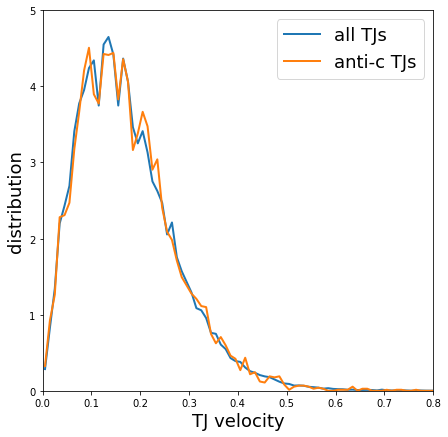

<Figure size 432x288 with 0 Axes>

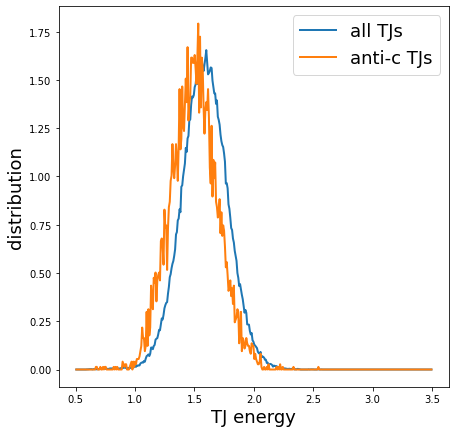

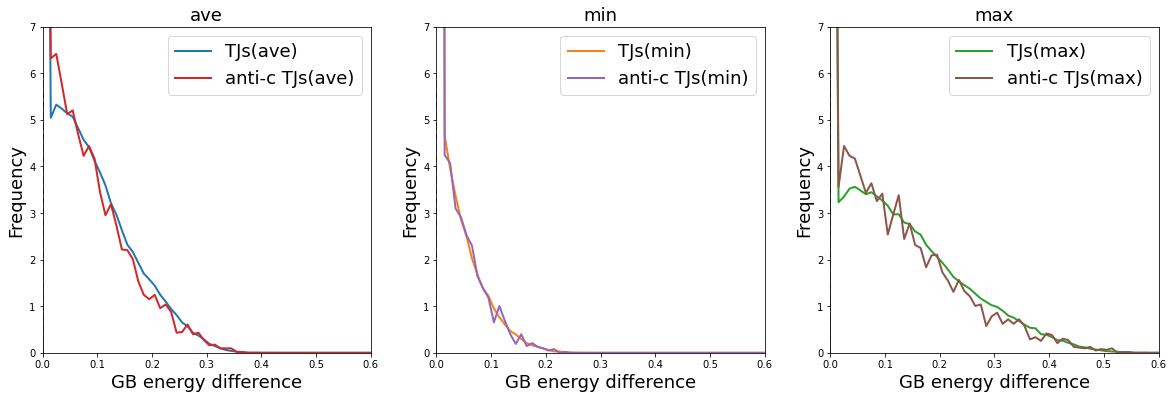

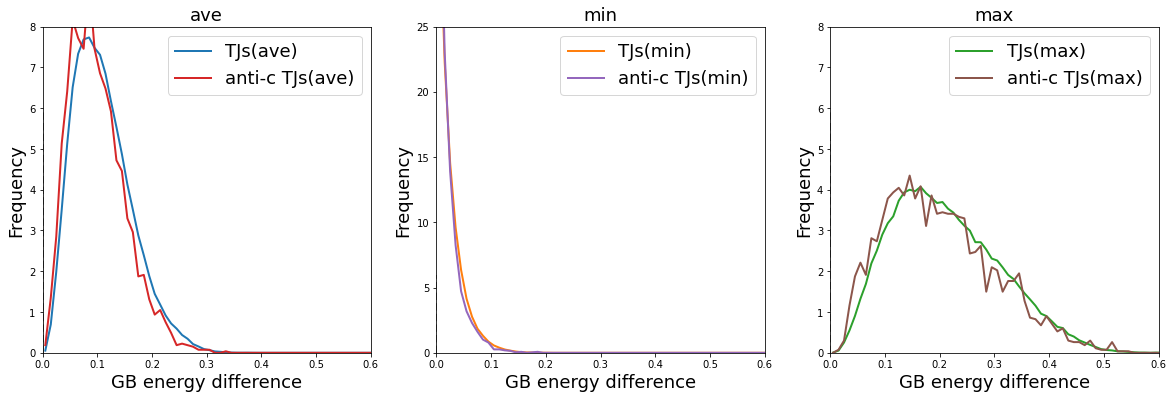

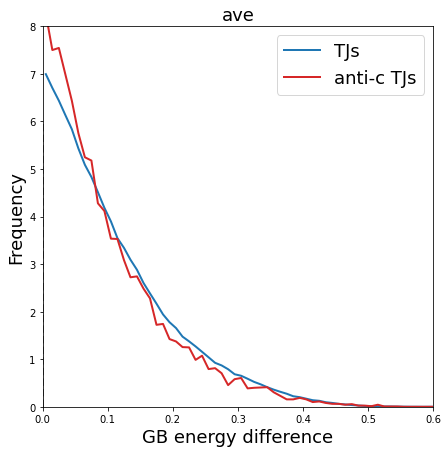

In [49]:

    xLim = [0,2.1]
    binValue = 0.01001
    binNum = round((abs(xLim[0])+abs(xLim[1]))/binValue)
    xCor = np.linspace((xLim[0]+binValue/2),(xLim[1]-binValue/2),binNum)
    xLim_energy = [0.5,3.5]
    binNum_energy = round((abs(xLim_energy[0])+abs(xLim_energy[1]))/binValue)
    xCor_energy = np.linspace((xLim_energy[0]+binValue/2),(xLim_energy[1]-binValue/2),binNum_energy)
    xLim_GBenergy = [0.0,1.2]
    binNum_GBenergy = round((abs(xLim_GBenergy[0])+abs(xLim_GBenergy[1]))/binValue)
    xCor_GBenergy = np.linspace((xLim_GBenergy[0]+binValue/2),(xLim_GBenergy[1]-binValue/2),binNum_GBenergy)
    xLim_GBDiffenergy = [-0.6,1.0]
    binNum_GBDiffenergy = round((abs(xLim_GBDiffenergy[0])+abs(xLim_GBDiffenergy[1]))/binValue)
    xCor_GBenergy_diff = np.linspace((xLim_GBDiffenergy[0]+binValue/2),(xLim_GBDiffenergy[1]-binValue/2),binNum_GBenergy)
    freqArray_velocity = np.zeros(binNum)
    freqArray_velocity_focus = np.zeros(binNum)
    freqArray_energy = np.zeros(binNum_energy)
    freqArray_energy_focus = np.zeros(binNum_energy)
    freqArray_GBenergy = np.zeros(binNum_GBenergy)
    freqArray_GBenergy_diff_three = np.zeros((3,binNum_GBenergy))
    freqArray_GBenergy_diff_four = np.zeros((3,binNum_GBenergy))
    freqArray_GBenergy_diff_four_all = np.zeros(binNum_GBenergy)
    freqArray_GBenergy_focus = np.zeros(binNum_GBenergy)
    freqArray_GBenergy_focus_diff_three = np.zeros((3,binNum_GBenergy))
    freqArray_GBenergy_focus_diff_four = np.zeros((3,binNum_GBenergy))
    freqArray_GBenergy_focus_diff_four_all = np.zeros(binNum_GBenergy)
    
    
    for site_i in range(len(TJ_velocity_1Dlist)):
        velocity = TJ_velocity_1Dlist[site_i]
        freqArray_velocity[int((velocity-xLim[0])//binValue)] += 1
        energy = TJ_energy_1Dlist[site_i]
        freqArray_energy[int((energy-xLim_energy[0])//binValue)] += 1
    freqArray_velocity = freqArray_velocity/np.sum(freqArray_velocity*binValue)
    freqArray_energy = freqArray_energy/np.sum(freqArray_energy*binValue)
    for site_i in range(len(TJ_focus_velocity_1Dlist)):
        velocity = TJ_focus_velocity_1Dlist[site_i]
        freqArray_velocity_focus[int((velocity-xLim[0])//binValue)] += 1
        energy = TJ_focus_energy_1Dlist[site_i]
        freqArray_energy_focus[int((energy-xLim_energy[0])//binValue)] += 1
    freqArray_velocity_focus = freqArray_velocity_focus/np.sum(freqArray_velocity_focus*binValue)
    freqArray_energy_focus = freqArray_energy_focus/np.sum(freqArray_energy_focus*binValue)
    for site_i in range(len(TJ_GBenergy_1Dlist)):
        GBenergy = TJ_GBenergy_1Dlist[site_i]
        freqArray_GBenergy[int((GBenergy-xLim_GBenergy[0])//binValue)] += 1
    freqArray_GBenergy = freqArray_GBenergy/np.sum(freqArray_GBenergy*binValue)
    for site_i in range(len(TJ_focus_GBenergy_1Dlist)):
        GBenergy = TJ_focus_GBenergy_1Dlist[site_i]
        freqArray_GBenergy_focus[int((GBenergy-xLim_GBenergy[0])//binValue)] += 1
    freqArray_GBenergy_focus = freqArray_GBenergy_focus/np.sum(freqArray_GBenergy_focus*binValue)
    for site_i in range(len(TJ_GBenergy_1Dlist_diff_three[0])):
        GBenergy0 = TJ_GBenergy_1Dlist_diff_three[0][site_i]
        GBenergy1 = TJ_GBenergy_1Dlist_diff_three[1][site_i]
        GBenergy2 = TJ_GBenergy_1Dlist_diff_three[2][site_i]
        freqArray_GBenergy_diff_three[0][int((GBenergy0-xLim_GBenergy[0])//binValue)] += 1
        freqArray_GBenergy_diff_three[1][int((GBenergy1-xLim_GBenergy[0])//binValue)] += 1
        freqArray_GBenergy_diff_three[2][int((GBenergy2-xLim_GBenergy[0])//binValue)] += 1
    freqArray_GBenergy_diff_three[0] = freqArray_GBenergy_diff_three[0]/np.sum(freqArray_GBenergy_diff_three[0]*binValue)
    freqArray_GBenergy_diff_three[1] = freqArray_GBenergy_diff_three[1]/np.sum(freqArray_GBenergy_diff_three[1]*binValue)
    freqArray_GBenergy_diff_three[2] = freqArray_GBenergy_diff_three[2]/np.sum(freqArray_GBenergy_diff_three[2]*binValue)
    for site_i in range(len(TJ_focus_GBenergy_1Dlist_diff_three[0])):
        GBenergy0 = TJ_focus_GBenergy_1Dlist_diff_three[0][site_i]
        GBenergy1 = TJ_focus_GBenergy_1Dlist_diff_three[1][site_i]
        GBenergy2 = TJ_focus_GBenergy_1Dlist_diff_three[2][site_i]
        freqArray_GBenergy_focus_diff_three[0][int((GBenergy0-xLim_GBenergy[0])//binValue)] += 1
        freqArray_GBenergy_focus_diff_three[1][int((GBenergy1-xLim_GBenergy[0])//binValue)] += 1
        freqArray_GBenergy_focus_diff_three[2][int((GBenergy2-xLim_GBenergy[0])//binValue)] += 1
    freqArray_GBenergy_focus_diff_three[0] = freqArray_GBenergy_focus_diff_three[0]/np.sum(freqArray_GBenergy_focus_diff_three[0]*binValue)
    freqArray_GBenergy_focus_diff_three[1] = freqArray_GBenergy_focus_diff_three[1]/np.sum(freqArray_GBenergy_focus_diff_three[1]*binValue)
    freqArray_GBenergy_focus_diff_three[2] = freqArray_GBenergy_focus_diff_three[2]/np.sum(freqArray_GBenergy_focus_diff_three[2]*binValue)
    # four GB energy
    for site_i in range(len(TJ_GBenergy_1Dlist_diff_four[0])):
        GBenergy0 = TJ_GBenergy_1Dlist_diff_four[0][site_i]
        GBenergy1 = TJ_GBenergy_1Dlist_diff_four[1][site_i]
        GBenergy2 = TJ_GBenergy_1Dlist_diff_four[2][site_i]
        freqArray_GBenergy_diff_four[0][int((GBenergy0-xLim_GBenergy[0])//binValue)] += 1
        freqArray_GBenergy_diff_four[1][int((GBenergy1-xLim_GBenergy[0])//binValue)] += 1
        freqArray_GBenergy_diff_four[2][int((GBenergy2-xLim_GBenergy[0])//binValue)] += 1
    freqArray_GBenergy_diff_four[0] = freqArray_GBenergy_diff_four[0]/np.sum(freqArray_GBenergy_diff_four[0]*binValue)
    freqArray_GBenergy_diff_four[1] = freqArray_GBenergy_diff_four[1]/np.sum(freqArray_GBenergy_diff_four[1]*binValue)
    freqArray_GBenergy_diff_four[2] = freqArray_GBenergy_diff_four[2]/np.sum(freqArray_GBenergy_diff_four[2]*binValue)
    for site_i in range(len(TJ_focus_GBenergy_1Dlist_diff_four[0])):
        GBenergy0 = TJ_focus_GBenergy_1Dlist_diff_four[0][site_i]
        GBenergy1 = TJ_focus_GBenergy_1Dlist_diff_four[1][site_i]
        GBenergy2 = TJ_focus_GBenergy_1Dlist_diff_four[2][site_i]
        freqArray_GBenergy_focus_diff_four[0][int((GBenergy0-xLim_GBenergy[0])//binValue)] += 1
        freqArray_GBenergy_focus_diff_four[1][int((GBenergy1-xLim_GBenergy[0])//binValue)] += 1
        freqArray_GBenergy_focus_diff_four[2][int((GBenergy2-xLim_GBenergy[0])//binValue)] += 1
    freqArray_GBenergy_focus_diff_four[0] = freqArray_GBenergy_focus_diff_four[0]/np.sum(freqArray_GBenergy_focus_diff_four[0]*binValue)
    freqArray_GBenergy_focus_diff_four[1] = freqArray_GBenergy_focus_diff_four[1]/np.sum(freqArray_GBenergy_focus_diff_four[1]*binValue)
    freqArray_GBenergy_focus_diff_four[2] = freqArray_GBenergy_focus_diff_four[2]/np.sum(freqArray_GBenergy_focus_diff_four[2]*binValue)
    # for all four enenrgy
    for site_i in range(len(TJ_GBenergy_1Dlist_diff_four_all)):
        GBenergy = TJ_GBenergy_1Dlist_diff_four_all[site_i]
        freqArray_GBenergy_diff_four_all[int((GBenergy-xLim_GBenergy[0])//binValue)] += 1
    freqArray_GBenergy_diff_four_all = freqArray_GBenergy_diff_four_all/np.sum(freqArray_GBenergy_diff_four_all*binValue)
    for site_i in range(len(TJ_focus_GBenergy_1Dlist_diff_four_all)):
        GBenergy = TJ_focus_GBenergy_1Dlist_diff_four_all[site_i]
        freqArray_GBenergy_focus_diff_four_all[int((GBenergy-xLim_GBenergy[0])//binValue)] += 1
    freqArray_GBenergy_focus_diff_four_all = freqArray_GBenergy_focus_diff_four_all/np.sum(freqArray_GBenergy_focus_diff_four_all*binValue)

    
    # plot
    figure_name_TJvelocity = f"figures/2D_TJ_velocity_{case_name}_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0,0.8])
    plt.ylim([0,5.0])
    plt.plot(xCor, freqArray_velocity,'-', linewidth=2,label='all TJs')
    plt.plot(xCor, freqArray_velocity_focus,'-', linewidth=2, label='anti-c TJs')
    plt.xlabel("TJ velocity", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    plt.legend(fontsize=18)
    # plt.savefig(figure_name_TJvelocity, dpi=400,bbox_inches='tight')
    
    # plot
    figure_name_TJenergy = f"figures/2D_TJ_energy_{case_name}_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.xlim([0,0.8])
    # plt.ylim([0,0.05])
    plt.plot(xCor_energy, freqArray_energy,'-', linewidth=2,label='all TJs')
    plt.plot(xCor_energy, freqArray_energy_focus,'-', linewidth=2, label='anti-c TJs')
    plt.xlabel("TJ energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    plt.legend(fontsize=18)
    # plt.savefig(figure_name_TJenergy, dpi=400,bbox_inches='tight')
    
    # plot
    figure_name_TJ_GBenergy = f"figures/2D_TJ_GBenergy_{case_name}_afterBin.png"
    plt.figure(figsize=(20,6))
    plt.subplot(131)
    plt.plot(xCor_GBenergy, freqArray_GBenergy_diff_three[0],'-', linewidth=2, label='TJs(ave)',color='C0')
    plt.plot(xCor_GBenergy, freqArray_GBenergy_focus_diff_three[0],'-', linewidth=2, label='anti-c TJs(ave)',color='C3')
    plt.plot([0,0],[0,6],'--', linewidth=2,color='grey')
    plt.xlim([0,0.6])
    plt.ylim([0,7])
    plt.xlabel("GB energy difference", fontsize=18)
    plt.ylabel("Frequency", fontsize=18)
    plt.legend(fontsize=18)
    plt.title('ave',fontsize=18)
    plt.subplot(132)
    plt.plot(xCor_GBenergy, freqArray_GBenergy_diff_three[1],'-', linewidth=2, label='TJs(min)',color='C1')
    plt.plot(xCor_GBenergy, freqArray_GBenergy_focus_diff_three[1],'-', linewidth=2, label='anti-c TJs(min)',color='C4')
    plt.plot([0,0],[0,6],'--', linewidth=2,color='grey')
    plt.xlim([0,0.6])
    plt.ylim([0,7])
    plt.xlabel("GB energy difference", fontsize=18)
    plt.ylabel("Frequency", fontsize=18)
    plt.legend(fontsize=18)
    plt.title('min',fontsize=18)
    plt.subplot(133)
    plt.plot(xCor_GBenergy, freqArray_GBenergy_diff_three[2],'-', linewidth=2, label='TJs(max)',color='C2')
    plt.plot(xCor_GBenergy, freqArray_GBenergy_focus_diff_three[2],'-', linewidth=2, label='anti-c TJs(max)',color='C5')
    plt.plot([0,0],[0,6],'--', linewidth=2,color='grey')
    plt.xlim([0,0.6])
    plt.ylim([0,7])
    plt.xlabel("GB energy difference", fontsize=18)
    plt.ylabel("Frequency", fontsize=18)
    plt.legend(fontsize=18)
    plt.title('max',fontsize=18)
    # print(f"The total is {len(TJ_GBenergy_1Dlist)}, the focus is {len(TJ_focus_GBenergy_1Dlist)}, the unfocus is {len(TJ_unfocus_GBenergy_1Dlist)}")
    # plt.savefig(figure_name_TJ_GBenergy, dpi=400,bbox_inches='tight')
    
    # plot focus on four GB energy
    figure_name_TJ_GBenergy = f"figures/2D_TJ_GBenergy_four_{case_name}_afterBin.png"
    plt.figure(figsize=(20,6))
    plt.subplot(131)
    plt.plot(xCor_GBenergy, freqArray_GBenergy_diff_four[0],'-', linewidth=2, label='TJs(ave)',color='C0')
    plt.plot(xCor_GBenergy, freqArray_GBenergy_focus_diff_four[0],'-', linewidth=2, label='anti-c TJs(ave)',color='C3')
    plt.plot([0,0],[0,6],'--', linewidth=2,color='grey')
    plt.xlim([0,0.6])
    plt.ylim([0,8])
    plt.xlabel("GB energy difference", fontsize=18)
    plt.ylabel("Frequency", fontsize=18)
    plt.legend(fontsize=18)
    plt.title('ave',fontsize=18)
    plt.subplot(132)
    plt.plot(xCor_GBenergy, freqArray_GBenergy_diff_four[1],'-', linewidth=2, label='TJs(min)',color='C1')
    plt.plot(xCor_GBenergy, freqArray_GBenergy_focus_diff_four[1],'-', linewidth=2, label='anti-c TJs(min)',color='C4')
    plt.plot([0,0],[0,6],'--', linewidth=2,color='grey')
    plt.xlim([0,0.6])
    plt.ylim([0,25])
    plt.xlabel("GB energy difference", fontsize=18)
    plt.ylabel("Frequency", fontsize=18)
    plt.legend(fontsize=18)
    plt.title('min',fontsize=18)
    plt.subplot(133)
    plt.plot(xCor_GBenergy, freqArray_GBenergy_diff_four[2],'-', linewidth=2, label='TJs(max)',color='C2')
    plt.plot(xCor_GBenergy, freqArray_GBenergy_focus_diff_four[2],'-', linewidth=2, label='anti-c TJs(max)',color='C5')
    plt.plot([0,0],[0,6],'--', linewidth=2,color='grey')
    plt.xlim([0,0.6])
    plt.ylim([0,8])
    plt.xlabel("GB energy difference", fontsize=18)
    plt.ylabel("Frequency", fontsize=18)
    plt.legend(fontsize=18)
    plt.title('max',fontsize=18)
    # print(f"The total is {len(TJ_GBenergy_1Dlist)}, the focus is {len(TJ_focus_GBenergy_1Dlist)}, the unfocus is {len(TJ_unfocus_GBenergy_1Dlist)}")
    # plt.savefig(figure_name_TJ_GBenergy, dpi=400,bbox_inches='tight')
    
    # plot all energy difference
    figure_name_TJ_GBenergy = f"figures/2D_TJ_GBenergy_four_all_{case_name}_afterBin.png"
    plt.figure(figsize=(7,7))
    plt.plot(xCor_GBenergy, freqArray_GBenergy_diff_four_all,'-', linewidth=2, label='TJs',color='C0')
    plt.plot(xCor_GBenergy, freqArray_GBenergy_focus_diff_four_all,'-', linewidth=2, label='anti-c TJs',color='C3')
    plt.plot([0,0],[0,6],'--', linewidth=2,color='grey')
    plt.xlim([0,0.6])
    plt.ylim([0,8])
    plt.xlabel("GB energy difference", fontsize=18)
    plt.ylabel("Frequency", fontsize=18)
    plt.legend(fontsize=18)
    plt.title('ave',fontsize=18)
    # print(f"The total is {len(TJ_GBenergy_1Dlist)}, the focus is {len(TJ_focus_GBenergy_1Dlist)}, the unfocus is {len(TJ_unfocus_GBenergy_1Dlist)}")
    # plt.savefig(figure_name_TJ_GBenergy, dpi=400,bbox_inches='tight')
    
    


In [272]:
    # extract TJ average velocity 
    time_interval = 30
    edge_matrix = np.array([[0,0,0],[size_x,0,0],[-size_x,0,0],[0,size_y,0],[0,-size_y,0],[size_x,size_y,0],[-size_x,-size_y,0],[-size_x,size_y,0],[size_x,-size_y,0]])
    
    init_TJ_keys = dict()
    mean_velocity_TJs = dict()
    for TJ_key in TJ_information_dict_list[0]: init_TJ_keys[TJ_key] = 0 # add all TJs in 0 step as init
    for time_step in range(1, step_num):
        
        for TJ_key in TJ_information_dict_list[time_step]:
            if TJ_key in init_TJ_keys: # know the init step
                if time_step==step_num-1 or TJ_key not in TJ_information_dict_list[time_step+1]: # last step for current TJs
                    # calculate velocity and keep it
                    init_step = init_TJ_keys[TJ_key]
                    location_init_step = TJ_information_dict_list[init_step][TJ_key][:3]
                    location_end_step = TJ_information_dict_list[time_step][TJ_key][:3]
                    difference_9points = np.tile(location_end_step,(9,1)) + edge_matrix - np.tile(location_init_step,(9,1))
                    distance_9points = np.linalg.norm(difference_9points,axis=1)
                    distance = np.min(distance_9points)
                    # calculate velocity
                    mean_velocity = distance / (time_interval*(time_step-init_step))
                    mean_velocity_TJs[TJ_key] = mean_velocity
            else: # don't know the init step
                init_TJ_keys[TJ_key] = time_step
    TJ_mean_velocity_1Dlist = list(mean_velocity_TJs.values())
    
    mean_velocity_focus_TJs = dict()
    for GB_key in tqdm(GB_id_focus_detail):
        if len(GB_id_focus_detail[GB_key]) < 2: continue
        init_step = GB_id_focus_detail[GB_key][0]
        end_step = GB_id_focus_detail[GB_key][-1]
        pair_id_pair_focus = GB_infomation_dict_list[init_step][GB_key][6:8]
        
        for TJ_key in TJ_information_dict_list[init_step]:
            if pair_id_pair_focus[0] in TJ_key and pair_id_pair_focus[1] in TJ_key:
                location_init_step = TJ_information_dict_list[init_step][TJ_key][:3]
                if TJ_key not in TJ_information_dict_list[end_step]: continue
                
                location_end_step = TJ_information_dict_list[end_step][TJ_key][:3]
                difference_9points = np.tile(location_end_step,(9,1)) + edge_matrix - np.tile(location_init_step,(9,1))
                distance_9points = np.linalg.norm(difference_9points,axis=1)
                distance = np.min(distance_9points)
                # calculate velocity
                mean_velocity = distance / (time_interval*(end_step-init_step))
                mean_velocity_focus_TJs[TJ_key] = mean_velocity
                
        
        # location_init_step = TJ_information_dict_list[init_step][TJ_key][:3]
        # location_end_step = TJ_information_dict_list[end_step][TJ_key][:3]
        # difference_9points = np.tile(location_end_step,(9,1)) + edge_matrix - np.tile(location_init_step,(9,1))
        # distance_9points = np.linalg.norm(difference_9points,axis=1)
        # distance = np.min(distance_9points)
        # # calculate velocity
        # mean_velocity = distance / (time_interval*(time_step-init_step))
        # mean_velocity_focus_TJs[TJ_key] = mean_velocity
    TJ_focus_mean_velocity_1Dlist = list(mean_velocity_focus_TJs.values())
    
        

100%|██████████| 1216/1216 [00:01<00:00, 748.69it/s] 


<Figure size 432x288 with 0 Axes>

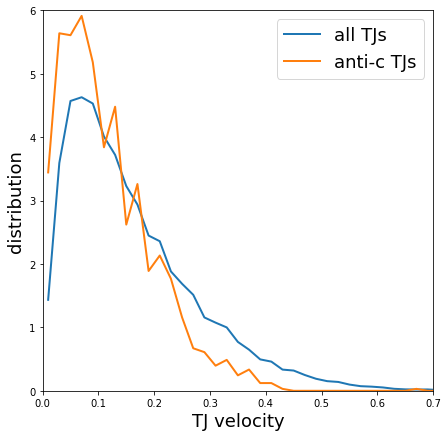

In [300]:

    xLim = [0,2.1]
    binValue = 0.02001
    binNum = round((abs(xLim[0])+abs(xLim[1]))/binValue)
    xCor = np.linspace((xLim[0]+binValue/2),(xLim[1]-binValue/2),binNum)
    freqArray_mean_velocity = np.zeros(binNum)
    freqArray_mean_velocity_focus = np.zeros(binNum)
    
    for site_i in range(len(TJ_mean_velocity_1Dlist)):
        mean_velocity = TJ_mean_velocity_1Dlist[site_i]
        freqArray_mean_velocity[int((mean_velocity-xLim[0])//binValue)] += 1
    freqArray_mean_velocity = freqArray_mean_velocity/np.sum(freqArray_mean_velocity*binValue)
    for site_i in range(len(TJ_focus_mean_velocity_1Dlist)):
        mean_velocity = TJ_focus_mean_velocity_1Dlist[site_i]
        freqArray_mean_velocity_focus[int((mean_velocity-xLim[0])//binValue)] += 1
    freqArray_mean_velocity_focus = freqArray_mean_velocity_focus/np.sum(freqArray_mean_velocity_focus*binValue)
    
    # plot
    figure_name_TJmeanvelocity = f"figures/2D_TJ_mean_velocity_{case_name}_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0,0.7])
    plt.ylim([0,6])
    plt.plot(xCor, freqArray_mean_velocity,'-', linewidth=2,label='all TJs')
    plt.plot(xCor, freqArray_mean_velocity_focus,'-', linewidth=2, label='anti-c TJs')
    plt.xlabel("TJ velocity", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    plt.legend(fontsize=18)
    # plt.savefig(figure_name_TJvelocity, dpi=400,bbox_inches='tight')
    


1640